In [1]:
import sys
# # sys.path.append('/global/cscratch1/sd/jianyao/ForSE/')
sys.path.append('/pscratch/sd/j/jianyao/forse_codes/') 
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *
# # sys.path.append('/pscratch/sd/j/jianyao/ForSE')
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import Reshape, Dense, Input
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
import numpy as np
import os
from tensorflow.keras import backend as K

import threading
from datetime import datetime
import time

In [5]:
import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

In [6]:
from pipeline_evaluation_NN import *

# My Forse

In [7]:
# dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_Q_jupyter/'

# dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_Q_jupyter/' # 20' to 3'
# dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_U_jupyter/' # 20' to 3'
# dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_from_12amin_348_models_MY_lr_5e-5_Q/' # 12' to 3'

dirs = '/pscratch/sd/j/jianyao/forse_output/Random_12amin_MY_lr_5e-5_Q_jupyter_snr_0p1/' # 20' to 3'
checkpoint_dir = dirs + 'training_checkpoints'

In [8]:
img_shape = (320, 320, 1); kernel_size = 5; cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True); channels = 1;
def build_generator():
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", input_shape=img_shape)) # 64x64x64
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", strides=2)) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(256, kernel_size=kernel_size, padding="same", strides=2)) #16x16x256
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(channels, kernel_size=kernel_size, padding="same"))
    model.add(Activation("tanh"))
    # img_in = Input(shape=img_shape)
    # img_out = model(img_in)
    # return Model(img_in, img_out)
    return model

def build_discriminator():

    model = Sequential()
    model.add(Conv2D(64, kernel_size=kernel_size, strides=1, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(256, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # img = Input(shape=img_shape)
    # validity = model(img)
    # return Model(img, validity)
    return model


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.00005, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00005, 0.5)

checkpoint_dir = dirs + 'training_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
        
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

### recover from the latest training epoch 
latest = tf.train.latest_checkpoint(checkpoint_dir);
if latest is not None:
    epoch_latest = np.int(re.findall(r'\d+', latest)[-1])*500
    print('restore from checkpoint:%s'% latest)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    
@tf.function
def train_step(noise, images):
    # noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def train(output_directory, epochs, patches_file, batch_size=32, save_interval=100, seed=4324):
    start = time.time()

    X_train, X_test, Y_train, Y_test = load_training_set(patches_file, part_train = 1, part_test = 0, seed=seed); # X-input large scales; Y-real small scales
    print("Training Data Shape: ", X_train.shape)
    half_batch = batch_size // 2
    accs = []
    
    if latest:
        epochs_range = range(epoch_latest, epochs)
        np.random.randint(0, X_train.shape[0], batch_size*(epoch_latest)) #To let the random start from lastest state, not the 0-state, which is state 4324
    else:
        epochs_range = range(epochs)
    
    for epoch in epochs_range:    
        now = time.time()

        ind_batch = np.random.randint(0, X_train.shape[0], batch_size)

        idxX = np.random.randint(0, X_train.shape[0], half_batch)
        idxY = np.random.randint(0, X_train.shape[0], half_batch)

        train_step(X_train[ind_batch], Y_train[idxY])
        if (epoch + 1) % save_interval == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            message = 'You are at epoch %s ! Time cost is %0.2f mins! ETA: %0.2f hours!'%(epoch, (now-start)/60, (epochs - epoch)*(now-start)/60/60/epoch)
            print(message)
            
    #         # gen_imgs_test = self.generator.predict(X_test)
    #         save_path = output_directory + "/models"
    #         if not os.path.exists(save_path):
    #             os.makedirs(save_path)
    #         discriminator.save(save_path + '/discrim_'+str(epoch)+'.h5')
    #         generator.save(save_path + '/generat_'+str(epoch)+'.h5')
    # discriminator.save(save_path + '/discrim_'+str(epoch)+'.h5')
    # generator.save(save_path + '/generat_'+str(epoch)+'.h5')


2022-10-24 12:19:29.446065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 12:19:30.678927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1375 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


restore from checkpoint:/pscratch/sd/j/jianyao/forse_output/Random_12amin_MY_lr_5e-5_Q_jupyter_snr_0p1/training_checkpoints/ckpt-400


## (Public, not only) from 80' to 12'

In [19]:
training_path = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/'
training_file = 'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy'
patch_file = training_path+training_file

In [25]:
ori_train = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')
np.random.seed(2048)
noise_0p1 = np.random.uniform(0, 1, (348, 320, 320))/10
for i in range(348):
    ori_train[1, i] = rescale_min_max(ori_train[1, i]) + noise_0p1[i]

np.save('/pscratch/sd/j/jianyao/forse_output/Random_training_data_Nico_T12amin_Q80amin.npy', ori_train)

In [10]:
ori_train = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')
np.random.seed(2048)
noise_0p1 = np.random.uniform(0, 1, (348, 320, 320))
for i in range(348):
    ori_train[1, i] = rescale_min_max(ori_train[1, i]) + noise_0p1[i]

np.save('/pscratch/sd/j/jianyao/forse_output/Random_snr_1_training_data_Nico_T12amin_Q80amin.npy', ori_train)

In [17]:
ori_train = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')
np.random.seed(2048)
noise_0p1 = np.random.uniform(0, 1, (348, 320, 320))*10
for i in range(348):
    ori_train[1, i] = rescale_min_max(ori_train[1, i]) + noise_0p1[i]

np.save('/pscratch/sd/j/jianyao/forse_output/Random_snr_0p1_training_data_Nico_T12amin_Q80amin.npy', ori_train)

In [18]:
dirs

'/pscratch/sd/j/jianyao/forse_output/Random_12amin_MY_lr_5e-5_Q_jupyter_snr_0p1/'

In [8]:
# tf.config.run_functions_eagerly(True)

# patch_file = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_Q20amin_348.npy'
# patch_file = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_Q20amin.npy'
# patch_file = '/pscratch/sd/j/jianyao/forse_output/Random_training_data_Nico_T12amin_Q80amin.npy'
patch_file = '/pscratch/sd/j/jianyao/forse_output/Random_snr_0p1_training_data_Nico_T12amin_Q80amin.npy'
# patch_file = '/pscratch/sd/j/jianyao/forse_output/Direct_training_data_Nico_T12amin_Q12amin.npy'
# patch_file = '/pscratch/sd/j/jianyao/forse_output/training_data_3amin.npy'
# patch_file = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348_35_36.npy'

In [130]:
train(output_directory= dirs, epochs=200001, patches_file=patch_file, batch_size=16, save_interval=500)

In [8]:
Thr, Ls_Q = np.load(patch_file)[:, 0:174]

In [9]:
Ls_Q.shape

(174, 320, 320)

In [10]:
Ls_Q_rescaled = np.zeros_like(Ls_Q)

for i in range(Ls_Q.shape[0]):
        
        Ls_Q_rescaled[i] = rescale_min_max(Ls_Q[i])

Ls_Q_rescaled = Ls_Q_rescaled.reshape((Ls_Q.shape[0], Ls_Q.shape[1], Ls_Q.shape[1], 1))

In [11]:
Ls_Q_rescaled.shape

(174, 320, 320, 1)

In [12]:
print(checkpoint_dir)
checkpoint.restore(checkpoint_dir + '/ckpt-53')

/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints


In [13]:
NN_out = generator.predict(Ls_Q_rescaled)

2022-06-07 05:16:21.140873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-07 05:16:22.685321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


In [14]:
NN_out.shape

(174, 320, 320, 1)

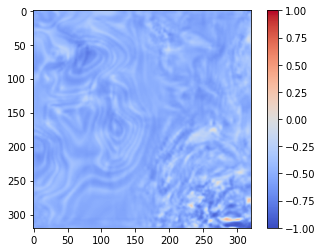

In [15]:
plt.imshow(NN_out[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

In [36]:
# fig, axes = plt.subplots(3,4, figsize = (20, 16))
# for i in range(3):
#     for j in range(4):
#         axes[i][j].imshow(NN_out[33+i*4+j*5], cmap='coolwarm')

### from 80' to 12' U

In [14]:
# dirs = '/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5_U/'
checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5_U_jupyter/training_checkpoints/ckpt-98')
Ls_U = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]

In [8]:
Ls_U_rescaled = np.zeros_like(Ls_U)

for i in range(Ls_U.shape[0]):
        
        Ls_U_rescaled[i] = rescale_min_max(Ls_U[i])

Ls_U_rescaled = Ls_U_rescaled.reshape((Ls_U.shape[0], Ls_U.shape[1], Ls_U.shape[1], 1))

In [15]:
NN_out_U = generator.predict(Ls_U_rescaled)

In [17]:
98*500

49000

In [18]:
np.save('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/New_TF_U_lr_5e-5_49000.npy', NN_out_U)

In [10]:
NN_Nico_U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_U_bs_16_Nico.npy')

In [37]:
# NN_Yao_U = NN_out_U
# fig, axes = plt.subplots(4,6, figsize = (20, 16))
# for i in range(4):
#     axes[i][0].imshow(NN_Nico_U[33+i*10], cmap='coolwarm')
#     axes[i][1].imshow(NN_Yao_U [33+i*10], cmap='coolwarm')
#     axes[i][2].imshow(NN_Nico_U[34+i*10], cmap='coolwarm')
#     axes[i][3].imshow(NN_Yao_U[34+i*10], cmap='coolwarm')
#     axes[i][4].imshow(NN_Nico_U[35+i*10], cmap='coolwarm')
#     axes[i][5].imshow(NN_Yao_U[35+i*10], cmap='coolwarm')

## from 12' to 3'

In [17]:
# Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_3amin.npy')[1]
Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy')[1]
Th_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy')[0]
# Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/Nico_Q_20amin.npy')
Ls_U_rescaled = np.zeros_like(Ls_U)
for i in range(Ls_U.shape[0]):
        
        Ls_U_rescaled[i] = rescale_min_max(Ls_U[i])

Ls_U_rescaled = Ls_U_rescaled.reshape((Ls_U.shape[0], Ls_U.shape[1], Ls_U.shape[1], 1))

print(Ls_U.shape)
print(Ls_U_rescaled.shape)

# Ls_U_part = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_for_3amin_348.npy')[1]
# Ls_U_part_rescaled = np.zeros_like(Ls_U_part)
# for i in range(Ls_U_part.shape[0]):
        
#         Ls_U_part_rescaled[i] = rescale_min_max(Ls_U_part[i])

# Ls_U_part_rescaled = Ls_U_part_rescaled.reshape((Ls_U_part.shape[0], Ls_U_part.shape[1], Ls_U_part.shape[1], 1))
# print(Ls_U_part.shape)
# print(Ls_U_part_rescaled.shape)

(348, 320, 320)
(348, 320, 320, 1)


In [38]:
# fig, axes = plt.subplots(4,6, figsize = (20, 16))
# for i in range(4):
#     for j in range(6):
#         axes[i][j].imshow(Th_U[33+i*2+j*10], cmap='coolwarm')

### use old model

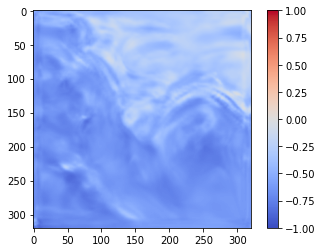

In [12]:
checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5/models/training_checkpoints/ckpt-16')

NN_out = generator.predict(Ls_U_rescaled)
plt.imshow(NN_out[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

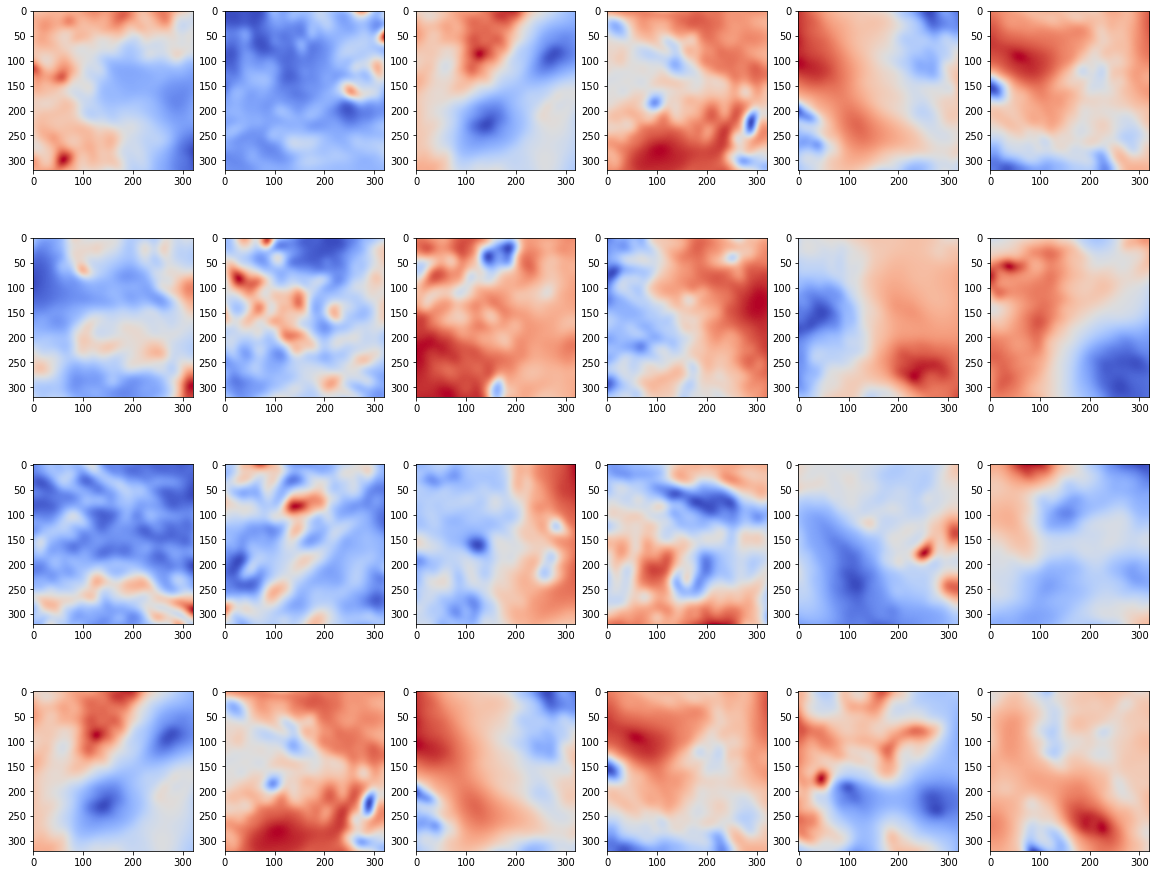

In [41]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    for j in range(6):
        axes[i][j].imshow(Ls_U_rescaled[330+i*40+j*60], cmap='coolwarm')

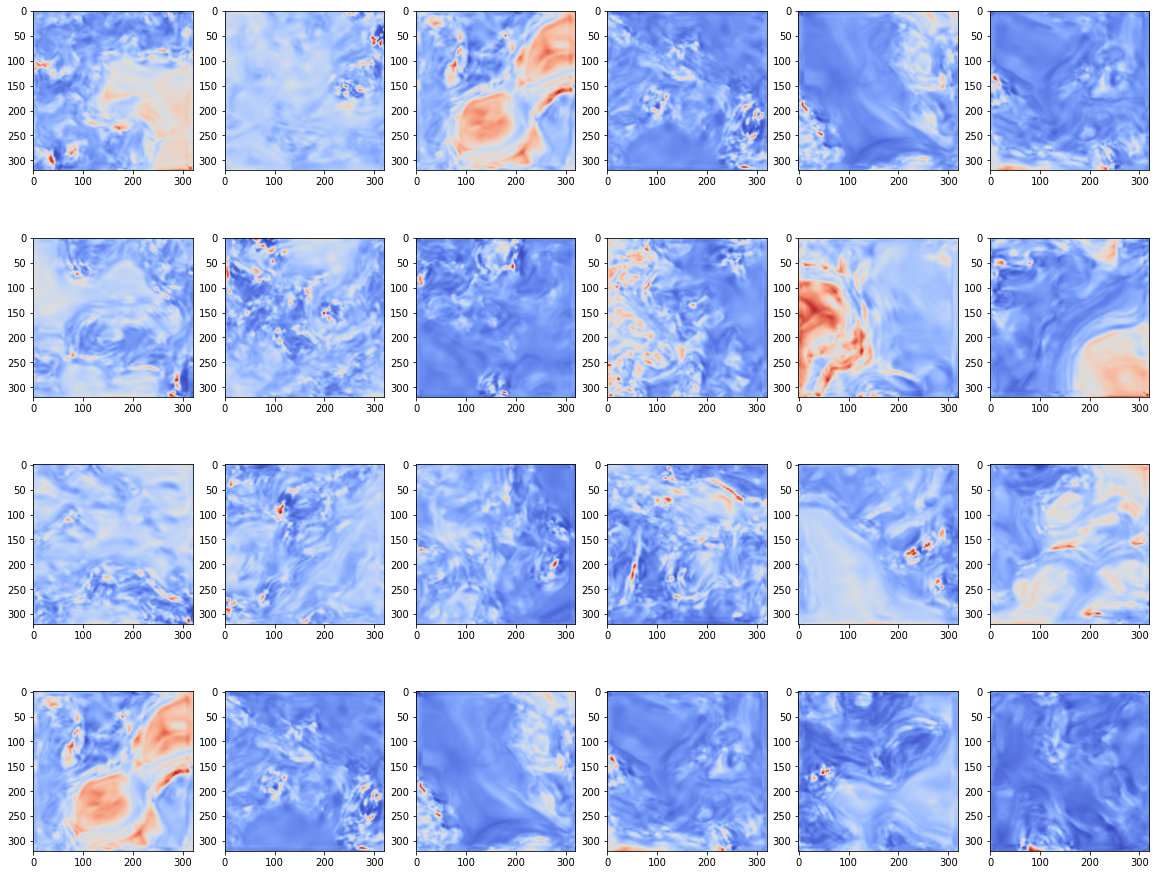

In [40]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    for j in range(6):
        axes[i][j].imshow(NN_out[330+i*40+j*60], cmap='coolwarm')

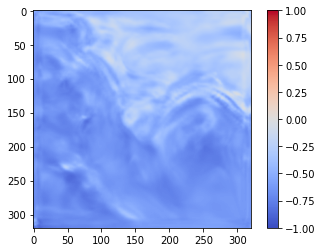

In [13]:
## for Nico's map at 20 arcmin
checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5/models/training_checkpoints/ckpt-16')

NN_out = generator.predict(Ls_U_rescaled)
plt.imshow(NN_out[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

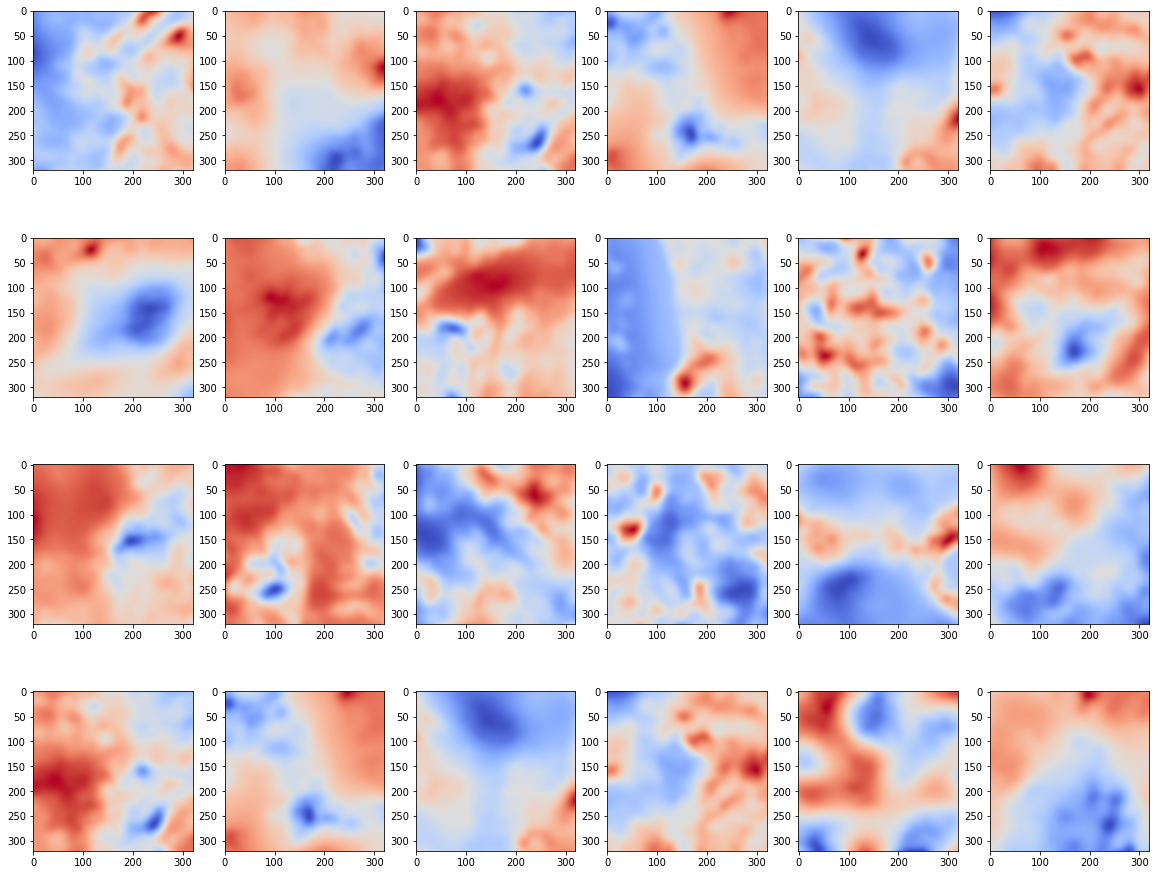

In [14]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    for j in range(6):
        axes[i][j].imshow(Ls_U_rescaled[330+i*40+j*60], cmap='coolwarm')

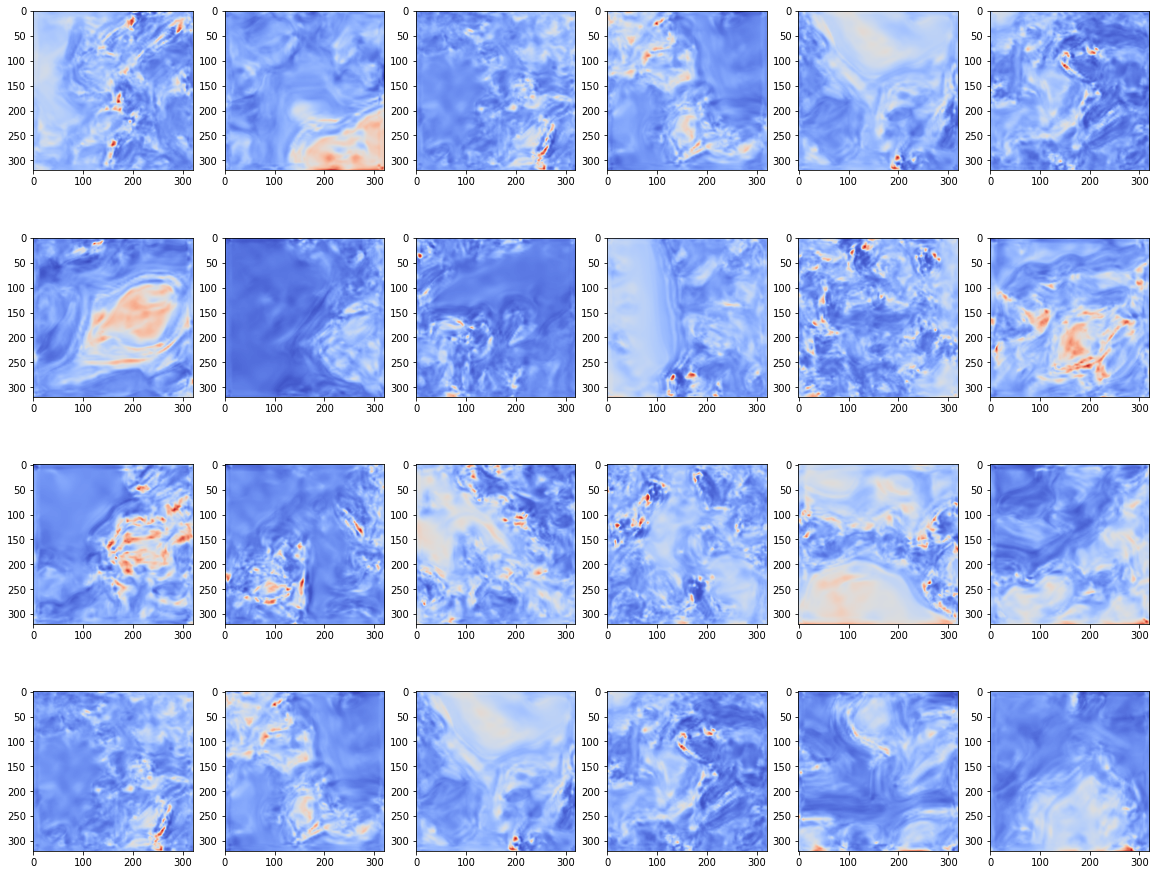

In [15]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    for j in range(6):
        axes[i][j].imshow(NN_out[330+i*40+j*60], cmap='coolwarm')

In [8]:
Nico_weights = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/weights/forse_generator_Q.h5'
generator_Q = tf.keras.models.load_model(Nico_weights) 
NNout_Q_NIco_model = generator_Q.predict(Ls_U_rescaled)

2022-05-30 14:16:56.441014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-30 14:16:57.848336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


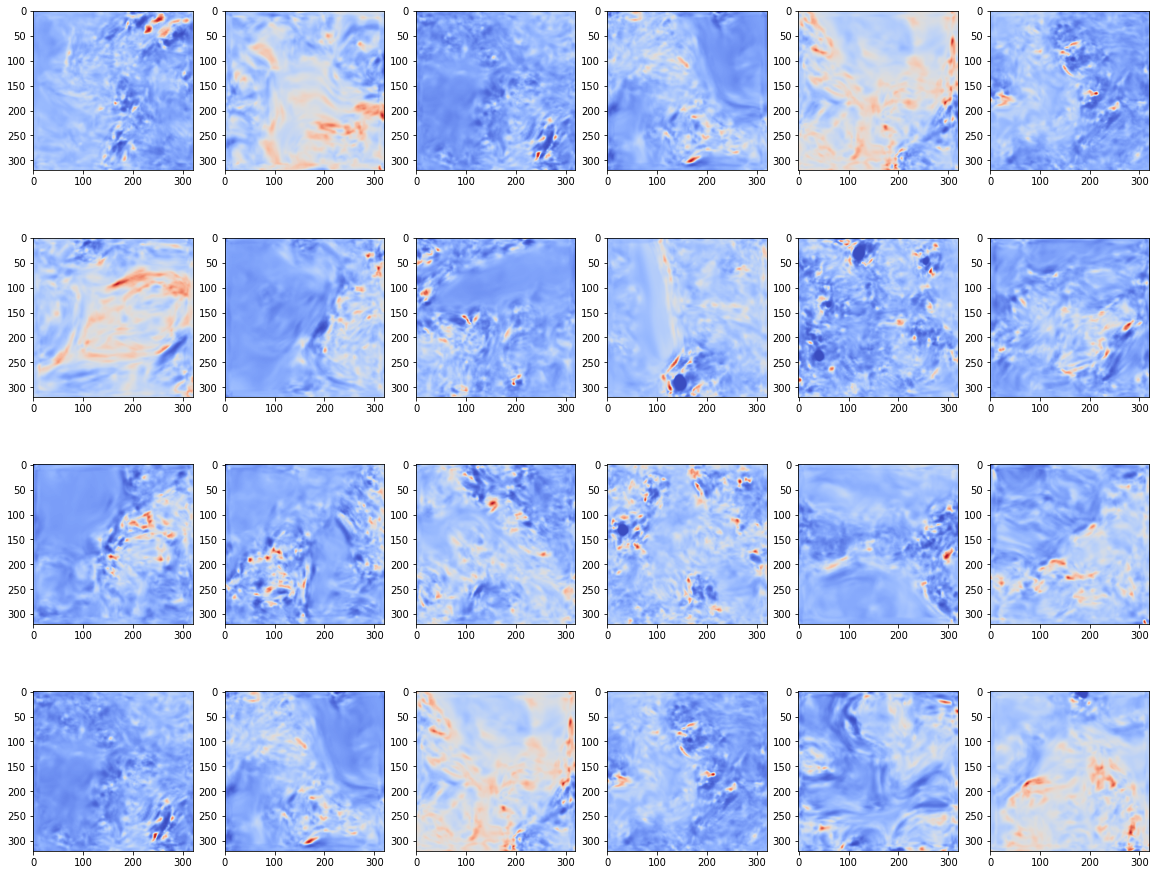

In [9]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    for j in range(6):
        axes[i][j].imshow(NNout_Q_NIco_model[330+i*40+j*60], cmap='coolwarm')

In [10]:
np.save('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Qout_3amin_Nico_20amin_Nico_model.npy', NNout_Q_NIco_model)

In [12]:
NNout_Q_NIco_model.shape

(8526, 320, 320, 1)

### use newly-trained model

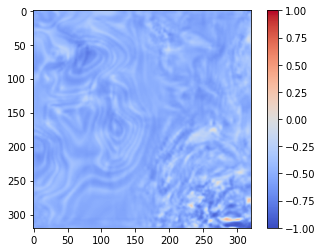

In [18]:
dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/'
checkpoint.restore(dirs + '/ckpt-53')

NN_out = generator.predict(Ls_U_rescaled)
plt.imshow(NN_out[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

In [33]:
NN_out.shape

(348, 320, 320, 1)

In [34]:
Ls_U.shape

(348, 320, 320)

In [39]:
# fig, axes = plt.subplots(4,6, figsize = (20, 16))
# for i in range(4):
#     for j in range(6):
#         axes[i][j].imshow(NN_out[33+i*2+j*10], cmap='coolwarm')

In [40]:
# fig, axes = plt.subplots(4,6, figsize = (20, 16))
# for i in range(4):
#     for j in range(6):
#         axes[i][j].imshow(NN_out[330+i*40+j*60], cmap='coolwarm')

In [41]:
# fig, axes = plt.subplots(4,6, figsize = (20, 16))
# for i in range(4):
#     for j in range(6):
#         axes[i][j].imshow(NN_out[2300+i*40+j*60], cmap='coolwarm')

In [42]:
# # epoch 185*500
# fig, axes = plt.subplots(4,6, figsize = (20, 16))
# for i in range(4):
#     for j in range(6):
#         axes[i][j].imshow(NN_out[330+i*40+j*60], cmap='coolwarm')

In [79]:
252*500

126000

## test np.random()

In [249]:
np.random.seed(4324)
# np.random.RandomState(seed = 4324)
train_indx = np.random.choice(8526, 8526)
np.random.randint(0, 8526, 16)

array([7099, 7878, 7808, 6470, 7296, 3152,  167, 7853, 6138, 7327, 7457,
       3684, 1570,  647, 2525, 7375])

In [252]:
np.random.randint(0, 8526, 16)

array([4479,  320, 6011, 7024, 3654, 4243, 2304, 2366,  199,  191, 2159,
       7525,  402, 5625, 6232,  308])

In [246]:
st0 = np.random.get_state()

In [247]:
np.random.randint(0, 8526, 16)

array([6271, 1589, 5313,  653, 5359, 7992, 7255, 7143, 5023, 1240,  715,
        869,  957, 5948, 5792, 2141])

In [248]:
np.random.randint(0, 8526, 16)

array([4479,  320, 6011, 7024, 3654, 4243, 2304, 2366,  199,  191, 2159,
       7525,  402, 5625, 6232,  308])

In [239]:
np.random.set_state(st0)
np.random.randint(0, 8526, 16)

array([6271, 1589, 5313,  653, 5359, 7992, 7255, 7143, 5023, 1240,  715,
        869,  957, 5948, 5792, 2141])

In [243]:
np.random.seed(4324)
train_indx = np.random.choice(8526, 8526)
np.random.randint(0, 8526, 48)
np.random.randint(0, 8526, 16)

array([4479,  320, 6011, 7024, 3654, 4243, 2304, 2366,  199,  191, 2159,
       7525,  402, 5625, 6232,  308])

In [254]:
52*500-1

25999

In [227]:
np.random.seed(2344)
np.random.randint(0, 8526, 8)

array([5461, 5650, 6033, 4182, 4669, 4520, 1551, 4385])

In [228]:
np.random.randint(0, 8526, 8)

array([2463, 6870, 4569, 6579, 1368, 2258, 4173, 3294])

In [221]:
np.random.seed(2344)
st0 = np.random.get_state()
np.random.randint(0, 8526, 16)

array([5461, 5650, 6033, 4182, 4669, 4520, 1551, 4385, 2463, 6870, 4569,
       6579, 1368, 2258, 4173, 3294])

In [222]:
np.random.randint(0, 8526, 16)

array([ 662, 1003, 4051, 7412, 7472, 4654,  802, 1544, 2697, 5005, 8013,
        980, 5461, 5816, 5142,  567])

In [226]:
np.random.set_state(st0)
np.random.randint(0, 8526, 16)

array([5461, 5650, 6033, 4182, 4669, 4520, 1551, 4385, 2463, 6870, 4569,
       6579, 1368, 2258, 4173, 3294])

# calculate the MFs

In [9]:
def get_MFs(input_patches = 348, data_dir = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_U/', MF_dir = "MFs/3_arcmin_MY_U_jupyter_348_MFs_lr_5e-5.txt", \
           best_epoch = False, save_NN = False):
    
    '''
    input_patches: the number of patches of input large scales
    '''
    
    if isinstance(data_dir, str):
        Thr, Ls = np.load(data_dir)[:, 0:174]
    else:
        Thr, Ls = data_dir

    Ls_rescaled = np.zeros_like(Ls)
    for i in range(Ls.shape[0]):

            Ls_rescaled[i] = rescale_min_max(Ls[i])

    Ls_rescaled = Ls_rescaled.reshape((Ls.shape[0], Ls.shape[1], Ls.shape[1], 1)) 

    rhos_t, f_t, u_t, chi_t = [], [], [], []
    npatches = 174
    for i in range(0,input_patches):

        mT = rescale_min_max(Thr[i], return_min_max=False)
        rhos_T, f_T, u_T, chi_T= get_functionals(mT)

        f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

    f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)
    
    def get_one_MF_only_NN(Ls_rescaled, k, save_NN = False):
        '''
        need to define checkpoint first
        '''
        checkpoint.restore(model_dir + 'training_checkpoints/ckpt-%s'%k)
        NNout = generator.predict(Ls_rescaled)
        print('NNout.shape:', NNout.shape)
        
        if save_NN:
            np.save(save_NN, NNout)

        rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
        if k % 10 == 0:
            print(k)
        for i in range(0,input_patches):

            mNN = rescale_min_max(NNout[i,:,:,0], return_min_max=False)
            rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

            f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

        f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

        m1_nnq = compute_intersection(rhos_T, 
                         [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                         [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                         npt=100000)
        m2_nnq = compute_intersection(rhos_T, 
                             [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                             [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                             npt=100000)
        m3_nnq = compute_intersection(rhos_T, 
                             [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                             [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                             npt=100000)
        return f_nn, u_nn, chi_nn, m1_nnq, m2_nnq, m3_nnq
    
    if not os.path.isfile(MF_dir):
        with open(MF_dir, "a") as o:

            for k in range(1, 400):
                f_nn, u_nn, chi_nn, m1_nnq, m2_nnq, m3_nnq = get_one_MF_only_NN(Ls_rescaled, k)
                o.write('%d %.2f %.2f %.2f\n'%(k, m1_nnq, m2_nnq, m3_nnq))
    if best_epoch:
        best_epoch = best_epoch
    else:
        best_epoch = plot_Overlapping(MF_dir)
    
    f_nn, u_nn, chi_nn, m1_nnq, m2_nnq, m3_nnq = get_one_MF_only_NN(Ls_rescaled, best_epoch, save_NN)
    print('%.2f %.2f %.2f'%(m1_nnq, m2_nnq, m3_nnq))
    return m1_nnq, m2_nnq, m3_nnq, rhos_T, f_t, u_t, chi_t, f_nn, u_nn, chi_nn, best_epoch
    

In [10]:
def plot_Overlapping(filename):
    data = np.loadtxt(filename)
    nepoches = len(data[:, 0])
    epoch = np.arange(1, nepoches + 1)
    mf_mean = np.mean(data[:, 1:4], axis = 1)
    index = np.argsort(mf_mean) + 1
    print('{%s, %0.3f}'%(index[-1], mf_mean[index[-1] - 1]), '{%s, %0.3f}'%(index[-2], mf_mean[index[-2] - 1]))
    print(data[index[-1]-1, 1:4], data[index[-2]-1, 1:4])
    plt.figure(figsize = (30,8))
    plt.scatter(epoch, data[:, 1],label = 'v1')
    plt.scatter(epoch, data[:, 2], label = 'v2')
    plt.scatter(epoch, data[:, 3], label = 'v3')
    plt.legend(fontsize = 25)
    plt.xticks(np.arange(1, nepoches, 10))
    plt.grid()
    return index[-1]

### calculate for 12' maps

In [72]:
45%10

5

In [13]:
def prepare_small_scales(Ls_Q, Ls_U, Ss_gauss_Q, Ss_gauss_U):
    
    npatches = len(Ls_Q)
    ls_Q = np.zeros_like(Ls_Q); ls_U = np.zeros_like(Ls_Q); ss_gauss_Q = np.zeros_like(Ls_Q); ss_gauss_U = np.zeros_like(Ls_Q)
    ss_gauss_Q_ratio, ss_gauss_U_ratio= Ss_gauss_Q/Ls_Q, Ss_gauss_U/Ls_U # Remove large scales (80') from the gaussian maps, according the definition of ss in the paper
    for i in range(npatches):
        
        ls_Q[i], ls_U[i] = rescale_min_max(Ls_Q[i]), rescale_min_max(Ls_U[i])
        ss_gauss_Q[i], ss_gauss_U[i] = rescale_min_max(ss_gauss_Q_ratio[i]), rescale_min_max(ss_gauss_U_ratio[i])
        
    return ls_Q.reshape((npatches, 320, 320, 1)), ls_U.reshape((npatches, 320, 320, 1)), ss_gauss_Q.reshape((npatches, 320, 320, 1)), ss_gauss_U.reshape((npatches, 320, 320, 1)),ss_gauss_Q_ratio,ss_gauss_U_ratio

dir_data = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/'

Thr, Ls_Q = np.load(dir_data+'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[:, 0:174]
Ls_U = np.load(dir_data+'GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]

Ss_gaussQ = np.load(dir_data+'GNILC_gaussian_ss_Q_20x20deg_Npix320_full_sky_adaptive.npy',  allow_pickle=True)
Ss_gaussU = np.load(dir_data+'GNILC_gaussian_ss_U_20x20deg_Npix320_full_sky_adaptive.npy',  allow_pickle=True)

Ls_scaled_Q, Ls_scaled_U, Ss_ratio_scaled_Q, Ss_ratio_scaled_U, Ss_ratio_Q, Ss_ratio_U = prepare_small_scales(Ls_Q, Ls_U, Ss_gaussQ, Ss_gaussU)

rhos_gss, f_gss, u_gss, chi_gss = [], [], [], []
rhos_t, f_t, u_t, chi_t = [], [], [], []
npatches = 174
for i in range(0,npatches):
    rhos_Y, f_Y, u_Y, chi_Y = get_functionals(Ss_ratio_scaled_U[i,:,:,0]) # change here !!!

    mT = rescale_min_max(Thr[i], return_min_max=False)
    rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    
    f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)
    f_gss.append(f_Y); u_gss.append(u_Y); chi_gss.append(chi_Y); 

f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)
f_gss = np.array(f_gss); u_gss = np.array(u_gss); chi_gss = np.array(chi_gss); 

with open("MFs/MY_U_MFs_lr_5e-5_jupyter.txt", "a") as o:
    
    for k in range(1, 201):
        
        if k%10 == 0:
            print('k=', k)

        checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5_U_jupyter/training_checkpoints/ckpt-%s'%k)
        NNout_Q = generator.predict(Ls_scaled_U) #change here!!!

        rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  

        for i in range(0,npatches):

            mNN = rescale_min_max(NNout_Q[i,:,:,0], return_min_max=False)
            rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

            f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

        f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

        m1_nnq = compute_intersection(rhos_Y, 
                         [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                         [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                         npt=100000)
        m2_nnq = compute_intersection(rhos_Y, 
                             [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                             [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                             npt=100000)
        m3_nnq = compute_intersection(rhos_Y, 
                             [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                             [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                             npt=100000)
        
        o.write('%d %.2f %.2f %.2f\n'%(k, m1_nnq, m2_nnq, m3_nnq))

k= 10
k= 20
k= 30
k= 40
k= 50
k= 60
k= 70
k= 80
k= 90
k= 100
k= 110
k= 120
k= 130
k= 140
k= 150
k= 160
k= 170
k= 180
k= 190
k= 200


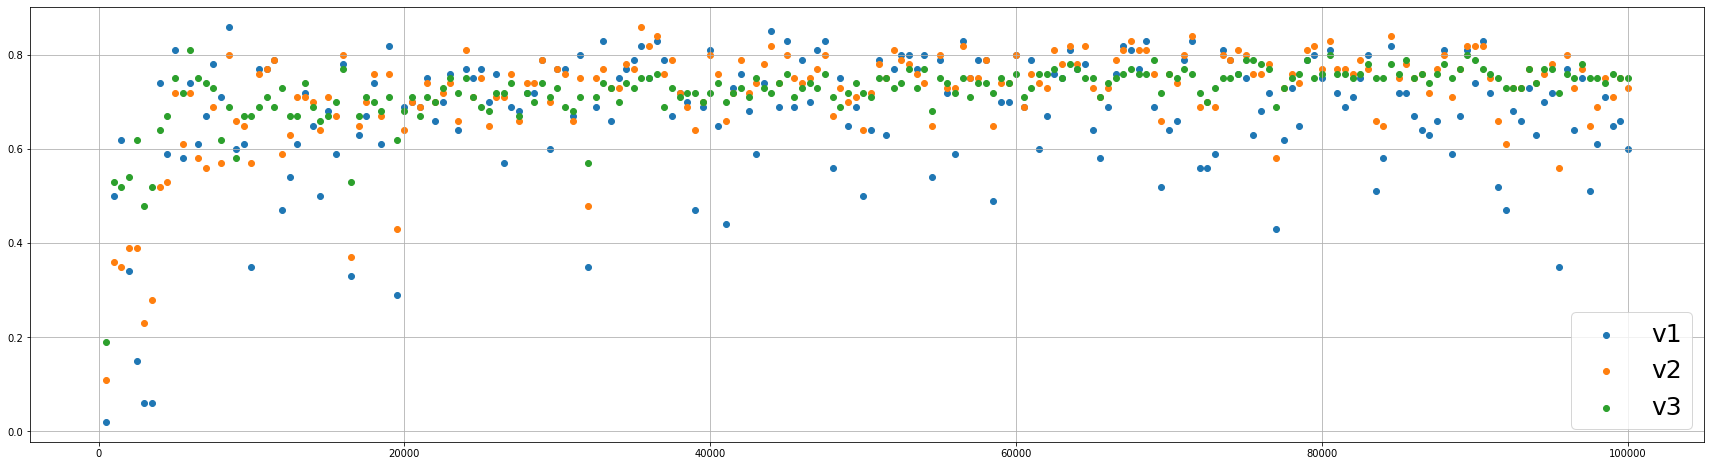

In [43]:
data = np.loadtxt('MFs/MY_Q_MFs_lr_5e-5.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 201)*500

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.grid()

In [12]:
49*500

24500

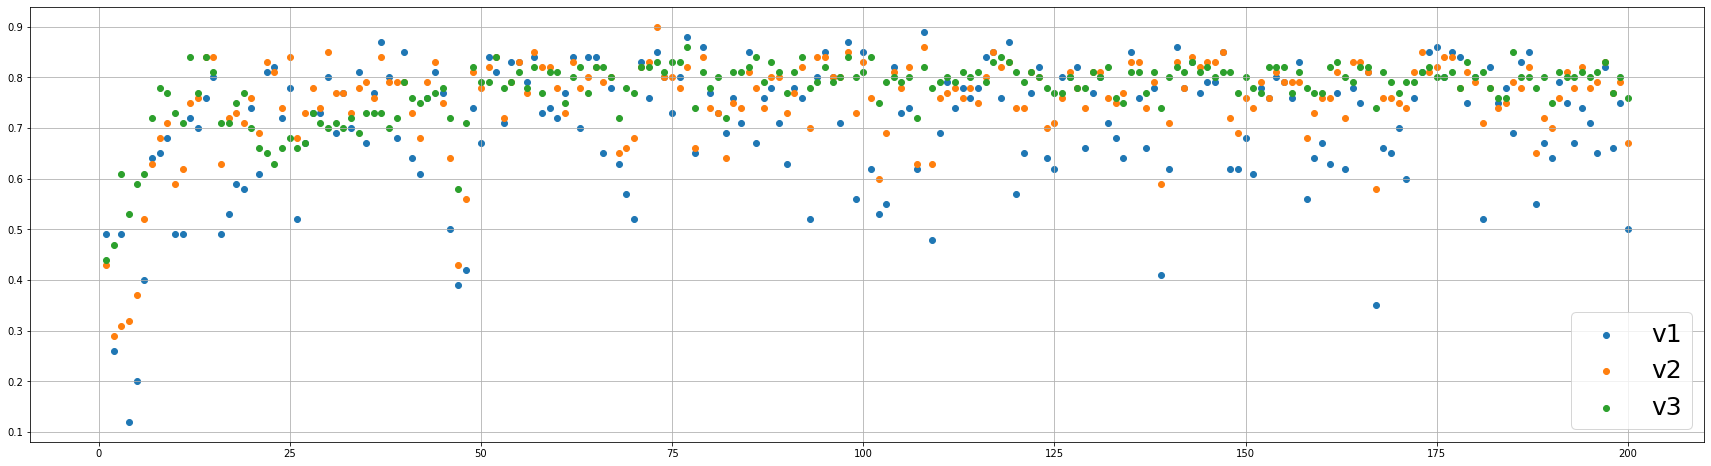

In [13]:
data = np.loadtxt('MFs/MY_U_MFs_lr_5e-5_jupyter.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 201)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.grid()

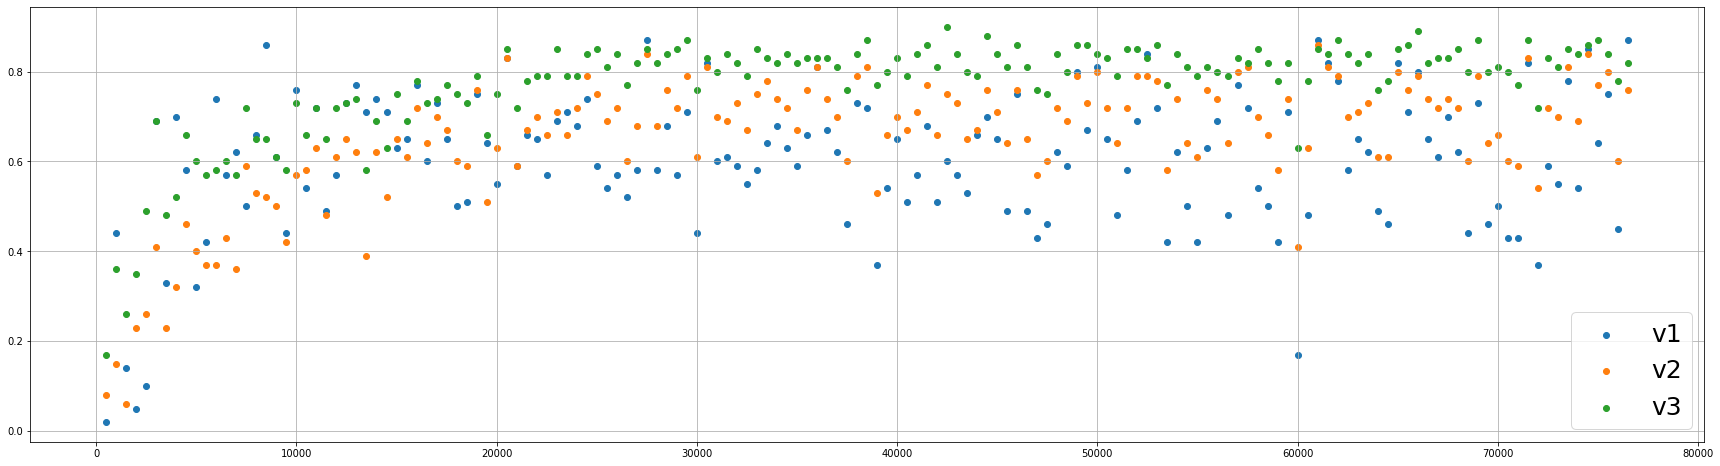

In [10]:
data = np.loadtxt('MFs/MY_U_MFs_lr_5e-5.txt') ## using multipole GPUs
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 154)*500

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.grid()

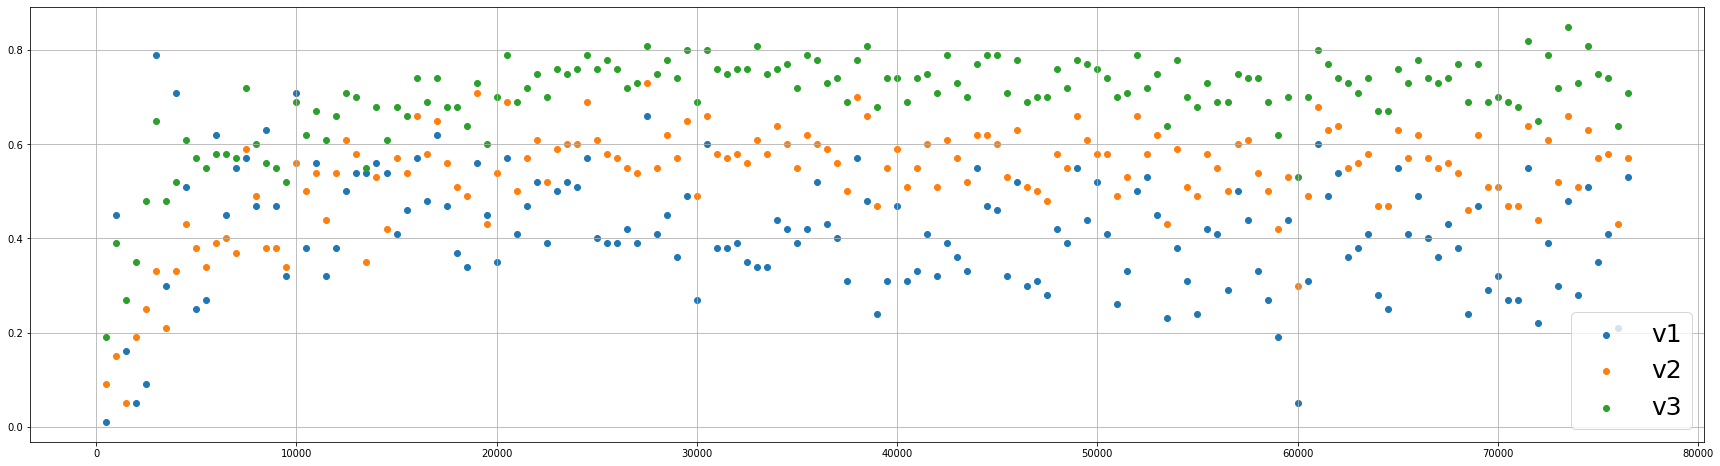

In [15]:
data = np.loadtxt('MFs/MY_U_MFs_lr_5e-5.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 154)*500

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.grid()

## calculate MFs for 3' with 348 patches

In [13]:
get_MFs(input_patches=348, data_dir = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_Q20amin_348.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_Q_jupyter/', MF_dir = "MFs/3_arcmin_MY_Q_jupyter_348_MFs_lr_5e-5.txt")

10
20
30
40
50
60
70
80
90
100
120
130
140
150
160
170
180
190


In [24]:
Thr_U, Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy')

Ls_U_rescaled = np.zeros_like(Ls_U)
for i in range(Ls_U.shape[0]):
        
        Ls_U_rescaled[i] = rescale_min_max(Ls_U[i])

Ls_U_rescaled = Ls_U_rescaled.reshape((Ls_U.shape[0], Ls_U.shape[1], Ls_U.shape[1], 1)) 


dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/'

rhos_t, f_t, u_t, chi_t = [], [], [], []
npatches = 174
for i in range(0,348):

    mT = rescale_min_max(Thr_U[i], return_min_max=False)
    rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    
    f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)


checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/ckpt-%s'%53)
NNout_Q = generator.predict(Ls_U_rescaled)

rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  

for i in range(0,348):

    mNN = rescale_min_max(NNout_Q[i,:,:,0], return_min_max=False)
    rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

    f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

m1_nnq = compute_intersection(rhos_T, 
                 [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                 [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                 npt=100000)
m2_nnq = compute_intersection(rhos_T, 
                     [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                     [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                     npt=100000)
m3_nnq = compute_intersection(rhos_T, 
                     [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                     [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                     npt=100000)

In [25]:
m1_nnq

0.7558927746109998

In [26]:
m2_nnq

0.8194039591037633

In [87]:
m3_nnq

0.8389124197294713

In [42]:
Thr_U, Ls_U_348 = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy')

In [70]:
Ls_U_348.shape

(348, 320, 320)

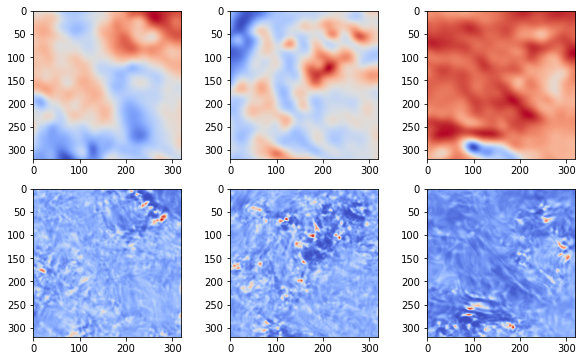

In [77]:
fig, axes = plt.subplots(2,3, figsize = (10,6))
axes[0,0].imshow(Ls_U_348[43])
axes[0,1].imshow(Ls_U_348[73])
axes[0,2].imshow(Ls_U_348[87])

axes[1,0].imshow(NNout_Q[43])
axes[1,1].imshow(NNout_Q[73])
axes[1,2].imshow(NNout_Q[87])

# axes[0,1].imshow(Ls_U[43])
# axes[1,1].imshow(Ls_U[73])
# axes[2,1].imshow(Ls_U[87])

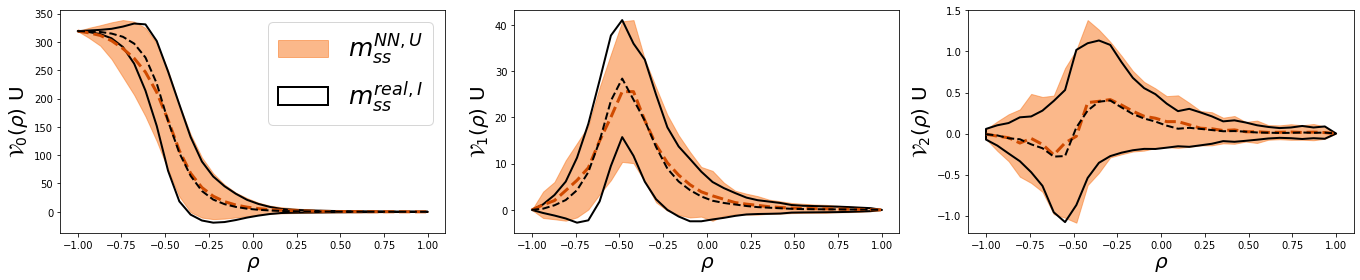

In [86]:
plt.figure(figsize=(19, 4))
rhos_Y = rhos_T

plt.subplot(131)
# plt.fill_between(rhos_Y, 
#                      np.mean(f_gss, axis=0)-np.std(f_gss, axis=0), 
#                      np.mean(f_gss, axis=0)+np.std(f_gss, axis=0), 
#                      lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
# plt.plot(rhos_Y, np.mean(f_gss, axis=0), lw=3, ls='--', color='#246830')
plt.fill_between(rhos_Y, 
                     np.mean(f_nn, axis=0)-np.std(f_nn, axis=0), 
                     np.mean(f_nn, axis=0)+np.std(f_nn, axis=0), 
                     lw=1, label=r'$m_{ss}^{NN, U}$', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(f_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(f_t, axis=0)-np.std(f_t, axis=0), 
                     np.mean(f_t, axis=0)+np.std(f_t, axis=0), 
                     lw=2, label = r'$m_{ss}^{real, I}$', edgecolor='black', facecolor='None')
plt.plot(rhos_Y, np.mean(f_t, axis=0), lw=2, ls='--', color='black')
plt.legend(fontsize = 25)
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_0(\rho$) U', fontsize=20)

plt.subplot(132)
# plt.fill_between(rhos_Y, 
#                      np.mean(u_gss, axis=0)-np.std(u_gss, axis=0), 
#                      np.mean(u_gss, axis=0)+np.std(u_gss, axis=0), 
#                      lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
# plt.plot(rhos_Y, np.mean(u_gss, axis=0), lw=3, ls='--', color='#246830')
plt.fill_between(rhos_Y, 
                     np.mean(u_nn, axis=0)-np.std(u_nn, axis=0), 
                     np.mean(u_nn, axis=0)+np.std(u_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(u_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(u_t, axis=0)-np.std(u_t, axis=0), 
                     np.mean(u_t, axis=0)+np.std(u_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor='black', facecolor='None')
plt.plot(rhos_Y, np.mean(u_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_1(\rho$) U', fontsize=20)

plt.subplot(133)
# plt.fill_between(rhos_Y, 
#                      np.mean(chi_gss, axis=0)-np.std(chi_gss, axis=0), 
#                      np.mean(chi_gss, axis=0)+np.std(chi_gss, axis=0), 
#                      lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
# plt.plot(rhos_Y, np.mean(chi_gss, axis=0), lw=3, ls='--', color='#246830')

plt.fill_between(rhos_Y, 
                     np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0), 
                     np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(chi_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), 
                     np.mean(chi_t, axis=0)+np.std(chi_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor='black', facecolor='None')
plt.plot(rhos_Y, np.mean(chi_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_2(\rho$) U', fontsize=20)
plt.tight_layout()

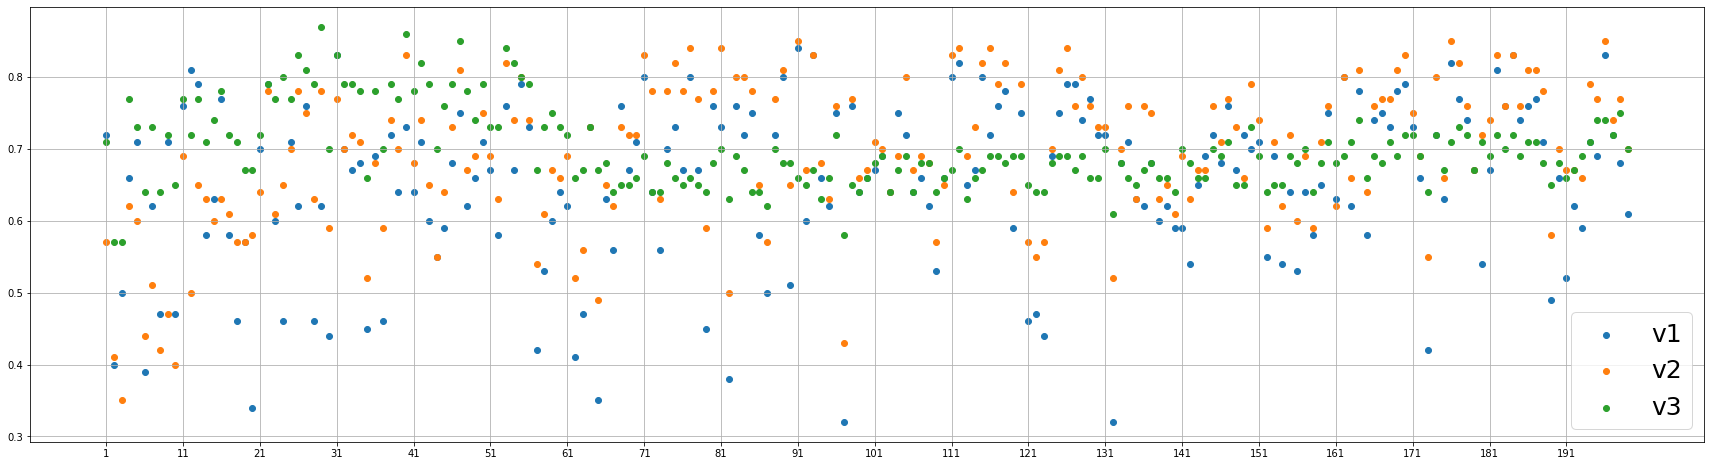

In [22]:
data = np.loadtxt('MFs/3_arcmin_MY_U_jupyter_348_MFs_lr_5e-5.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 200)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1, 200, 10))
plt.grid()

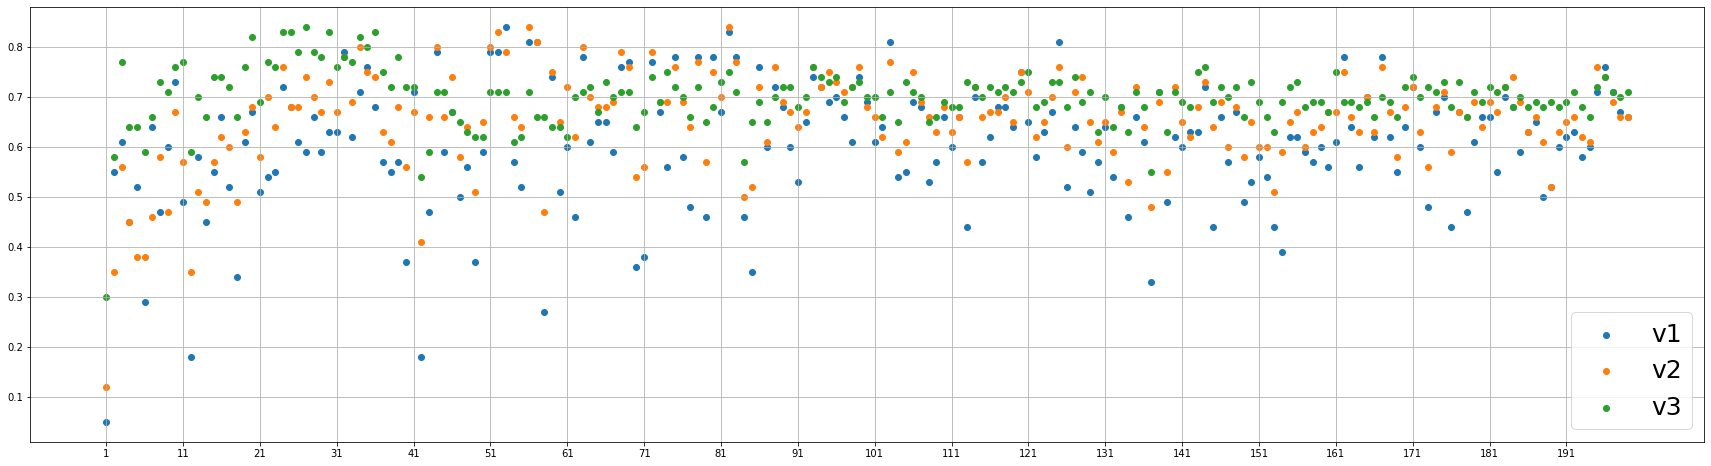

In [14]:
plot_Overlapping('MFs/3_arcmin_MY_Q_jupyter_348_MFs_lr_5e-5.txt')

## MFs for 3' with other 348 patches

In [ ]:
get_MFs(input_patches=348, data_dir = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348_35_36.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter_35_36/', MF_dir = "MFs/3_arcmin_MY_U_jupyter_348_35_36_MFs_lr_5e-5.txt")

10
20
30
40
50
70
80
90
100
110
120
130
140
150
160
170


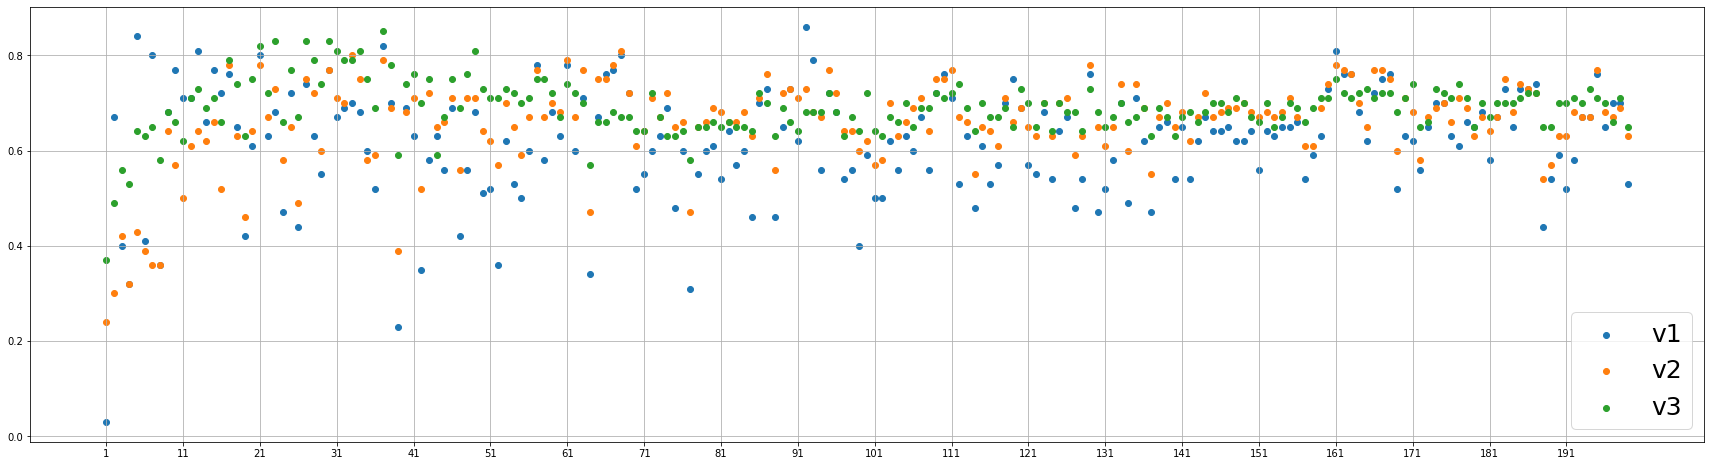

In [32]:
plot_Overlapping("MFs/3_arcmin_MY_U_jupyter_348_35_36_MFs_lr_5e-5.txt")

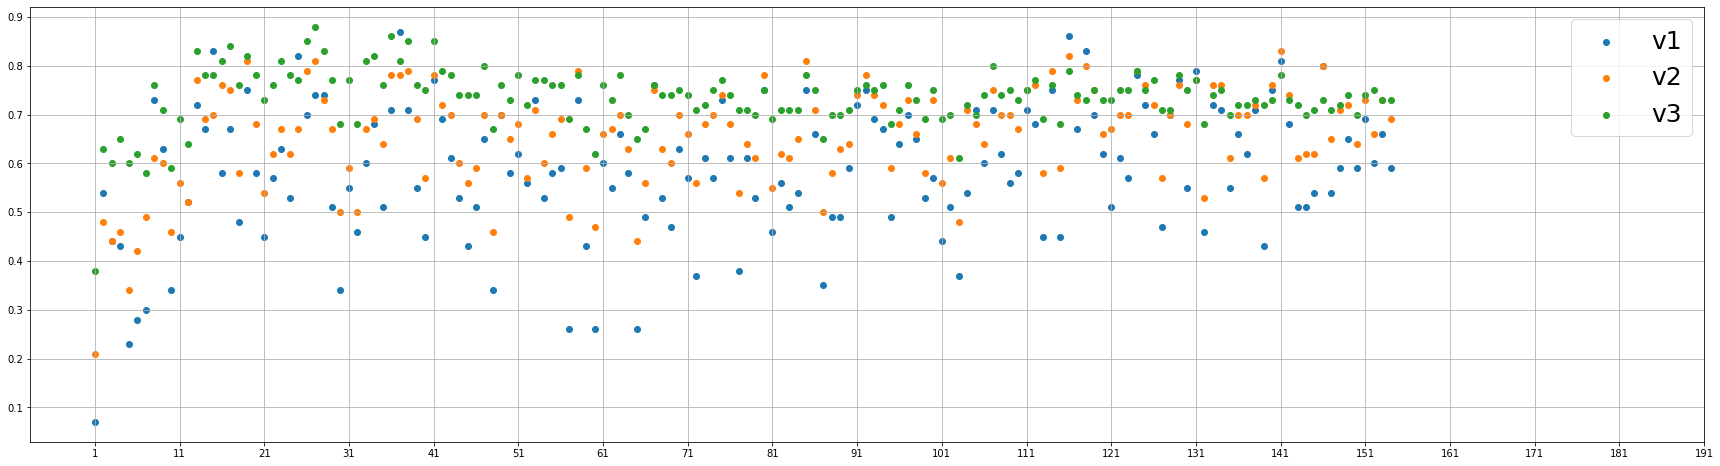

In [23]:
data = np.loadtxt('MFs/3_arcmin_MY_U_jupyter_348_7_9_MFs_lr_5e-5.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 155)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1, 200, 10))
plt.grid()

## MFs for 3' with models for patches 5:7 on patches 7:11:2

In [9]:
get_MFs(input_patches=348, data_dir = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348_7_9.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/', MF_dir = "MFs/3_arcmin_MY_U_jupyter_348_5_6_on_7_9_MFs_lr_5e-5.txt")

2022-06-16 05:24:12.037389: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-16 05:24:13.715299: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


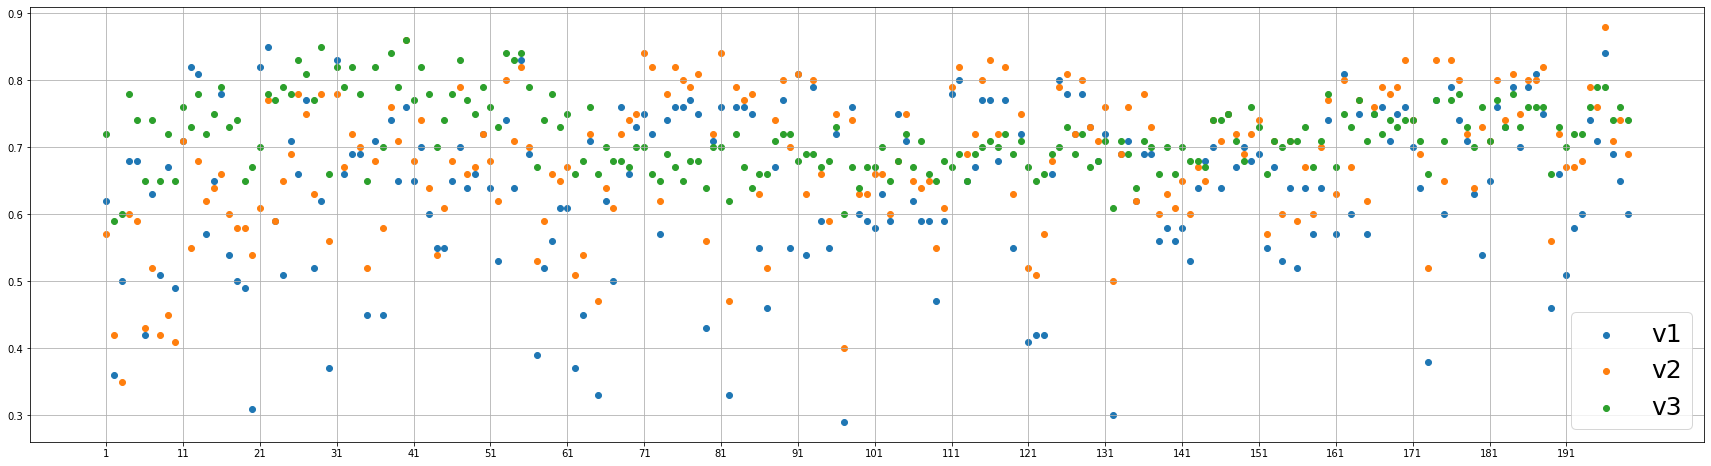

In [11]:
plot_Overlapping('MFs/3_arcmin_MY_U_jupyter_348_5_6_on_7_9_MFs_lr_5e-5.txt')

## train on small patches, test on full-sky

In [ ]:
Thr_U, Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy')

Ls_U_rescaled = np.zeros_like(Ls_U)
for i in range(Ls_U.shape[0]):
        
        Ls_U_rescaled[i] = rescale_min_max(Ls_U[i])

Ls_U_rescaled = Ls_U_rescaled.reshape((Ls_U.shape[0], Ls_U.shape[1], Ls_U.shape[1], 1)) 


dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/'

rhos_t, f_t, u_t, chi_t = [], [], [], []
npatches = 174
for i in range(0,348):

    mT = rescale_min_max(Thr_U[i], return_min_max=False)
    rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    
    f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)


checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/ckpt-%s'%53)
NNout_Q = generator.predict(Ls_U_rescaled)

rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  

for i in range(0,348):

    mNN = rescale_min_max(NNout_Q[i,:,:,0], return_min_max=False)
    rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

    f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

m1_nnq = compute_intersection(rhos_T, 
                 [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                 [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                 npt=100000)
m2_nnq = compute_intersection(rhos_T, 
                     [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                     [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                     npt=100000)
m3_nnq = compute_intersection(rhos_T, 
                     [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                     [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                     npt=100000)

## MFs for 3' from 12' directly

In [12]:
get_MFs(input_patches=174, data_dir = '/pscratch/sd/j/jianyao/forse_output/Direct_training_data_Nico_T12amin_Q12amin.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_from_12amin_348_models_MY_lr_5e-5_Q/', MF_dir = "MFs/3_arcmin_from_12amin_MY_Q_jupyter_348_MFs_lr_5e-5.txt")

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


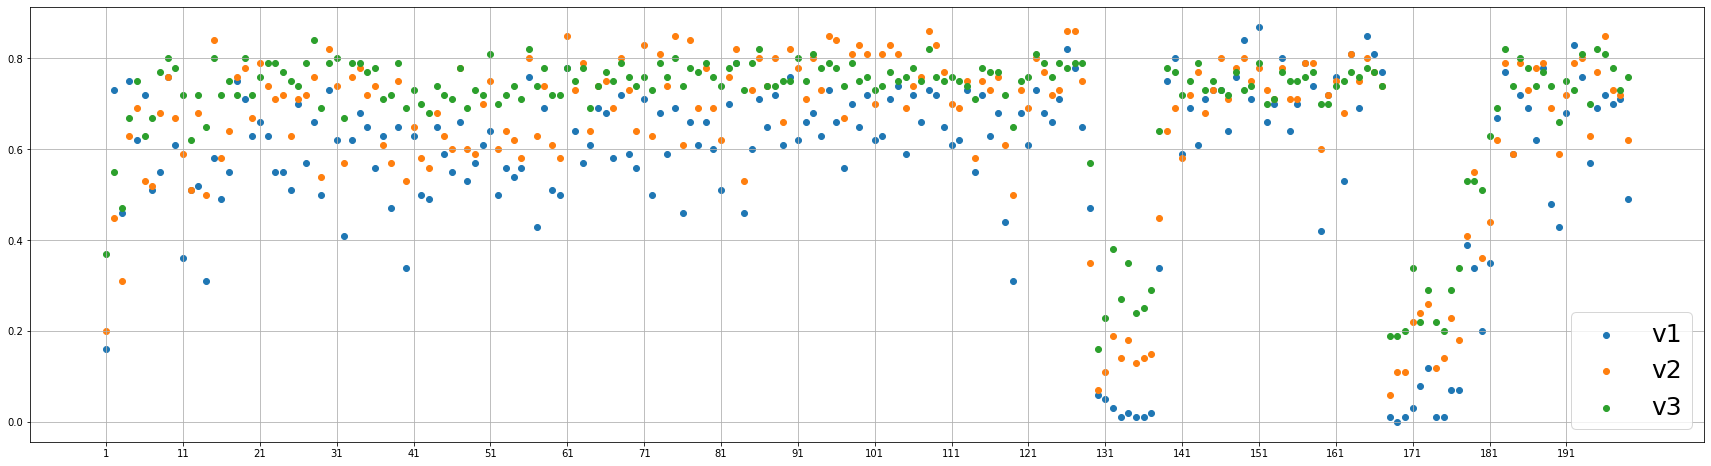

In [13]:
data = np.loadtxt('MFs/3_arcmin_from_12amin_MY_Q_jupyter_348_MFs_lr_5e-5.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 200)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1, 200, 10))
plt.grid()

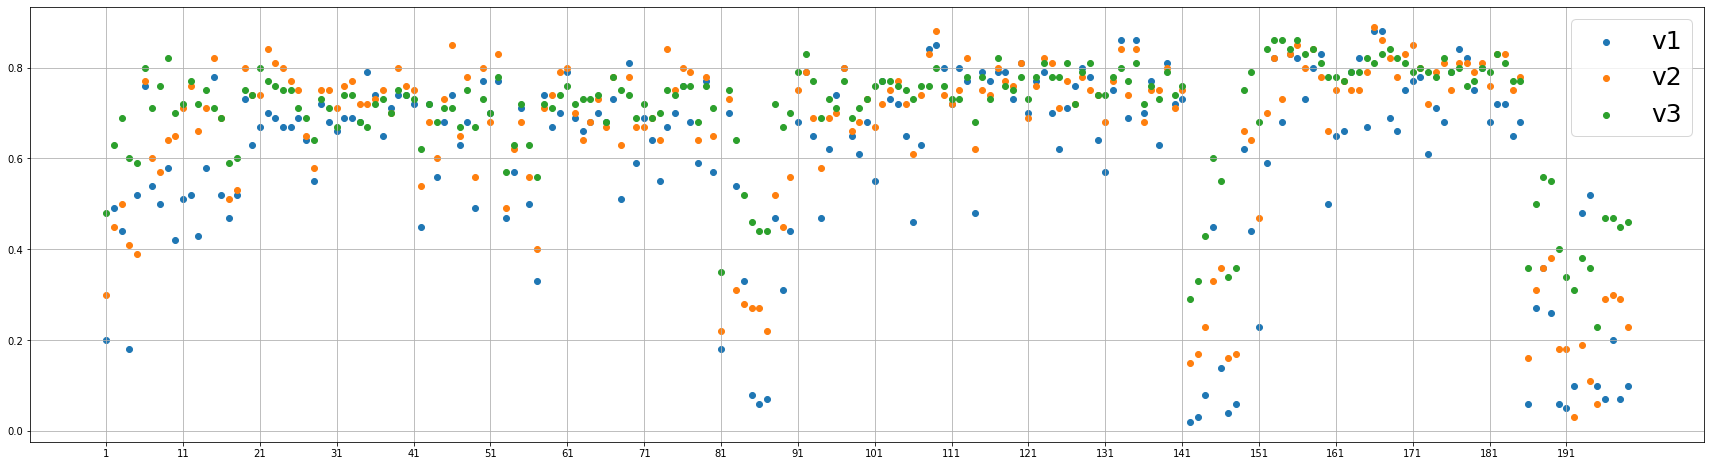

In [24]:
data = np.loadtxt('MFs/3_arcmin_from_12amin_MY_U_jupyter_348_MFs_lr_5e-5.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 200)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1, 200, 10))
plt.grid()

## U-calculate MFs for 3' with 8000 patches, but only for 348 patches 

In [14]:
Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin.npy')[1].reshape(174, 49, 320, 320)[:, 5:7, :, :].reshape(348, 320, 320)

In [7]:
Ls_U .shape

(348, 320, 320)

In [15]:

Thr_U = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[0]

Ls_U_rescaled = np.zeros_like(Ls_U)
for i in range(Ls_U.shape[0]):
        
        Ls_U_rescaled[i] = rescale_min_max(Ls_U[i])

Ls_U_rescaled = Ls_U_rescaled.reshape((Ls_U.shape[0], Ls_U.shape[1], Ls_U.shape[1], 1)) # (8526, 320, 320, 1)

dir_models = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_U_jupyter/training_checkpoints/'

rhos_t, f_t, u_t, chi_t = [], [], [], []
npatches = 174
for i in range(0,348):

    mT = rescale_min_max(Thr_U[i], return_min_max=False)
    rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    
    f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)

with open("MFs/3_arcmin_8000_models_MY_lr_5e-5_U_jupyter_348.txt", "a") as o:
    
    for k in range(1, 400):

        checkpoint.restore(dir_models+'ckpt-%s'%k)
        NNout_Q = generator.predict(Ls_U_rescaled)

        rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
        if k % 10 == 0:
            print(k)
            
        for i in range(0,348):

            mNN = rescale_min_max(NNout_Q[i,:,:,0], return_min_max=False)
            rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

            f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

        f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

        m1_nnq = compute_intersection(rhos_T, 
                         [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                         [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                         npt=100000)
        m2_nnq = compute_intersection(rhos_T, 
                             [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                             [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                             npt=100000)
        m3_nnq = compute_intersection(rhos_T, 
                             [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                             [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                             npt=100000)
        
        o.write('%d %.2f %.2f %.2f\n'%(k, m1_nnq, m2_nnq, m3_nnq))

10
20
30
40
50
60
80
90
100
110
120
130
140
150
160
170
180
190
200


KeyboardInterrupt: 

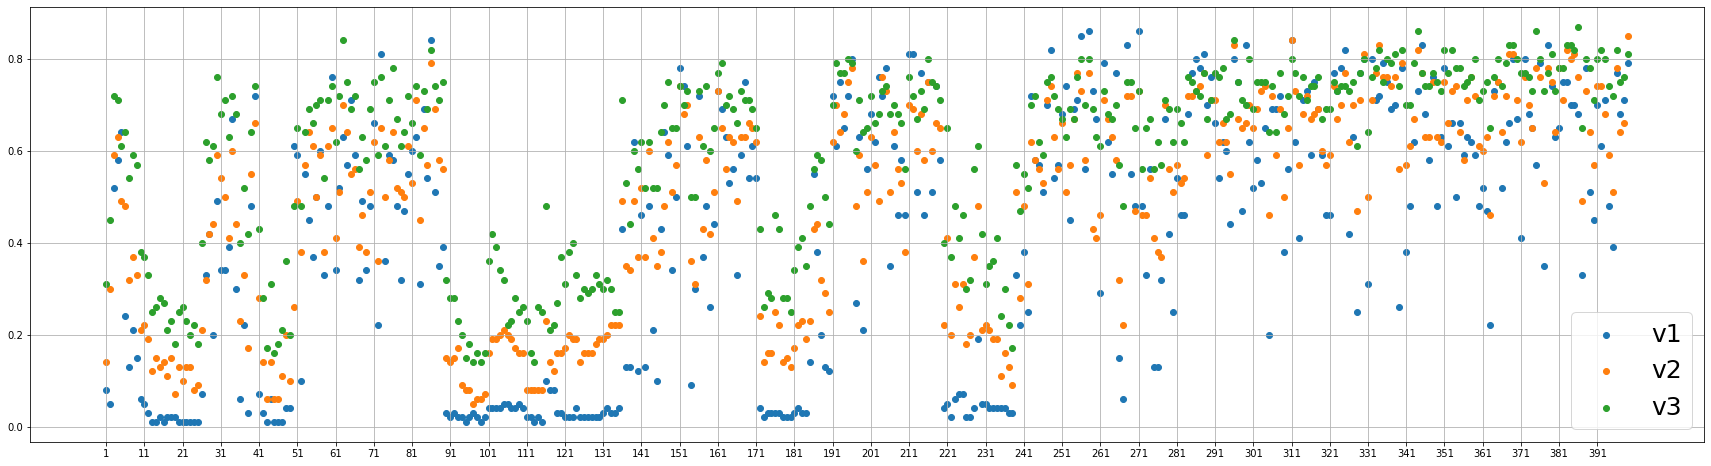

In [13]:
data = np.loadtxt('MFs/3_arcmin_8000_models_MY_lr_5e-5_U_jupyter_348.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1, 400)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1, 400, 10))
plt.grid()

## Q-calculate MFs for 3' with 8000 patches, but only for 348 patches 

In [18]:
Ls_Q = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_Q20amin.npy')[1].reshape(174, 49, 320, 320)[:, 5:7, :, :].reshape(348, 320, 320)
Thr_Q = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[0]

In [19]:
get_MFs(input_patches=348, data_dir = np.array((Thr_Q, Ls_Q)), \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_Q_jupyter/', MF_dir = "MFs/3_arcmin_8000_models_MY_lr_5e-5_Q_jupyter_348.txt")

200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


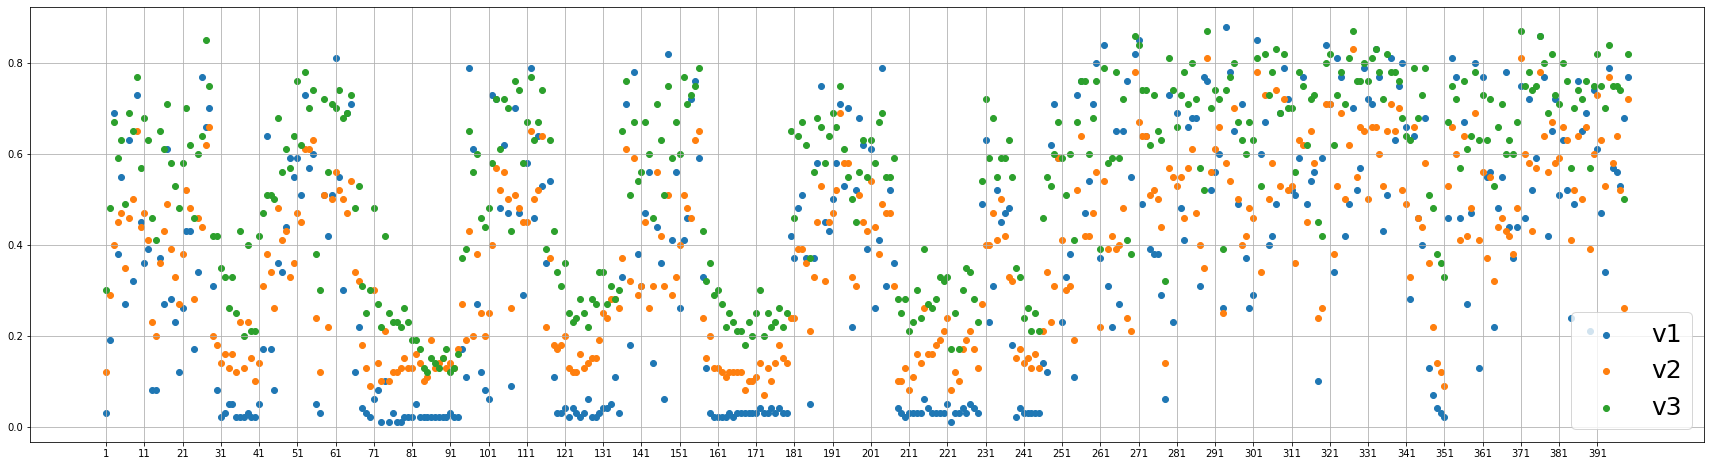

In [20]:
plot_Overlapping('MFs/3_arcmin_8000_models_MY_lr_5e-5_Q_jupyter_348.txt')

## 12arcmin, random noise + LS as input with SNR = 10

### generate the training file and test file (different realizations of noise)

In [11]:
print('%03d'%100)

100


In [234]:
ori_test = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')
np.random.seed(4096)

for n in range(100):
    
    noise_0p1 = np.random.uniform(0, 1, (348, 320, 320))/10
    for i in range(348):
        ori_test[1, i] = rescale_min_max(ori_test[1, i]) + noise_0p1[i]

    np.save('/pscratch/sd/j/jianyao/forse_output/Random_training_files/Random_10_testing_data/Random_10_testing_data_Nico_T12amin_Q80amin_%03d.npy'%n, ori_test)

In [236]:
snr = [0.1, 1, 10]
names = ['0p1', '1', '10']

In [237]:
ori_test = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')

for k in range(0,2):
    np.random.seed(4096)
    
    for n in range(100):
        noise = np.random.uniform(0, 1, (348, 320, 320))*snr[k]
        for i in range(348):
            ori_test[1, i] = rescale_min_max(ori_test[1, i]) + noise[i]

        np.save('/pscratch/sd/j/jianyao/forse_output/Random_training_files/Random_%s_testing_data/Random_%s_testing_data_Nico_T12amin_Q80amin_%03d.npy'%(names[k], names[k], n), ori_test)

In [6]:
ori_test = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')
np.random.seed(4096)
noise_0p1 = np.random.uniform(0, 1, (348, 320, 320))
for i in range(348):
    ori_test[1, i] = rescale_min_max(ori_test[1, i]) + noise_0p1[i]

np.save('/pscratch/sd/j/jianyao/forse_output/Random_1_testing_data_Nico_T12amin_Q80amin.npy', ori_test)

### MFs check

{135, 0.827} {164, 0.820}
[0.85 0.85 0.78] [0.85 0.82 0.79]
NNout.shape: (174, 320, 320, 1)
0.86 0.85 0.78
NNout.shape: (174, 320, 320, 1)
0.63 0.70 0.73


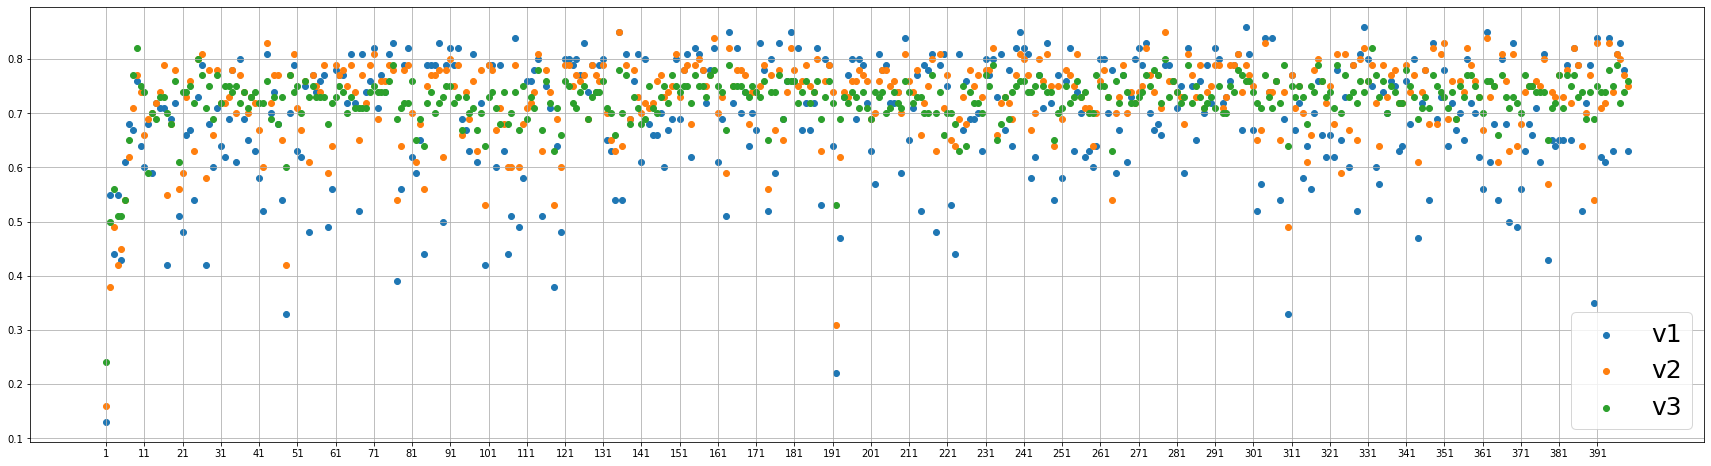

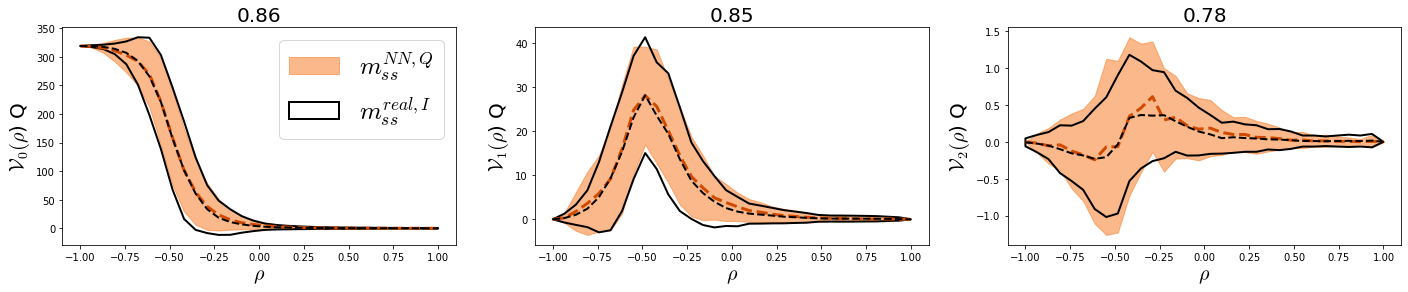

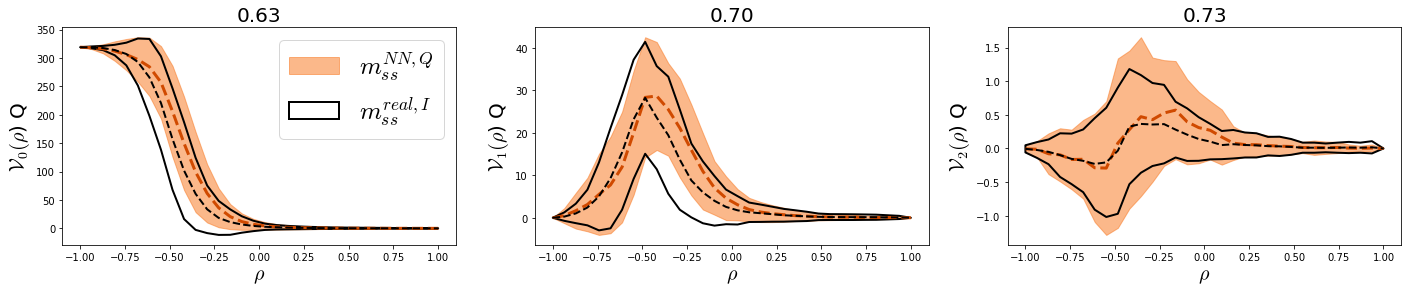

In [164]:
data_dir = '/pscratch/sd/j/jianyao/forse_output/Random_training_data_Nico_T12amin_Q80amin.npy'
model_dir = '/pscratch/sd/j/jianyao/forse_output/Random_12amin_MY_lr_5e-5_Q_jupyter/'
MF_dir = 'MFs/Random_snr_10_Q_jupyter_348_MFs_lr_5e-5.txt'

results = get_MFs(input_patches=174, data_dir = data_dir, model_dir = model_dir, MF_dir = MF_dir)
plot_MF(results, 'Q', savedir = False)

## test the model with another realization of noise
test_noise = '/pscratch/sd/j/jianyao/forse_output/Random_10_testing_data_Nico_T12amin_Q80amin.npy'
data_test = np.load(test_noise)[:, 0:174]

results_test = get_MFs(input_patches=174, data_dir = data_test, model_dir = model_dir, MF_dir = MF_dir, best_epoch = results[10], save_NN='/pscratch/sd/j/jianyao/forse_output/NN_small_scales/Random_10_NNout_Q.npy')
plot_MF(results_test, 'Q', savedir = False)

{358, 0.820} {374, 0.820}
[0.88 0.83 0.75] [0.85 0.84 0.77]
NNout.shape: (174, 320, 320, 1)
0.87 0.83 0.75
NNout.shape: (174, 320, 320, 1)
0.41 0.53 0.69


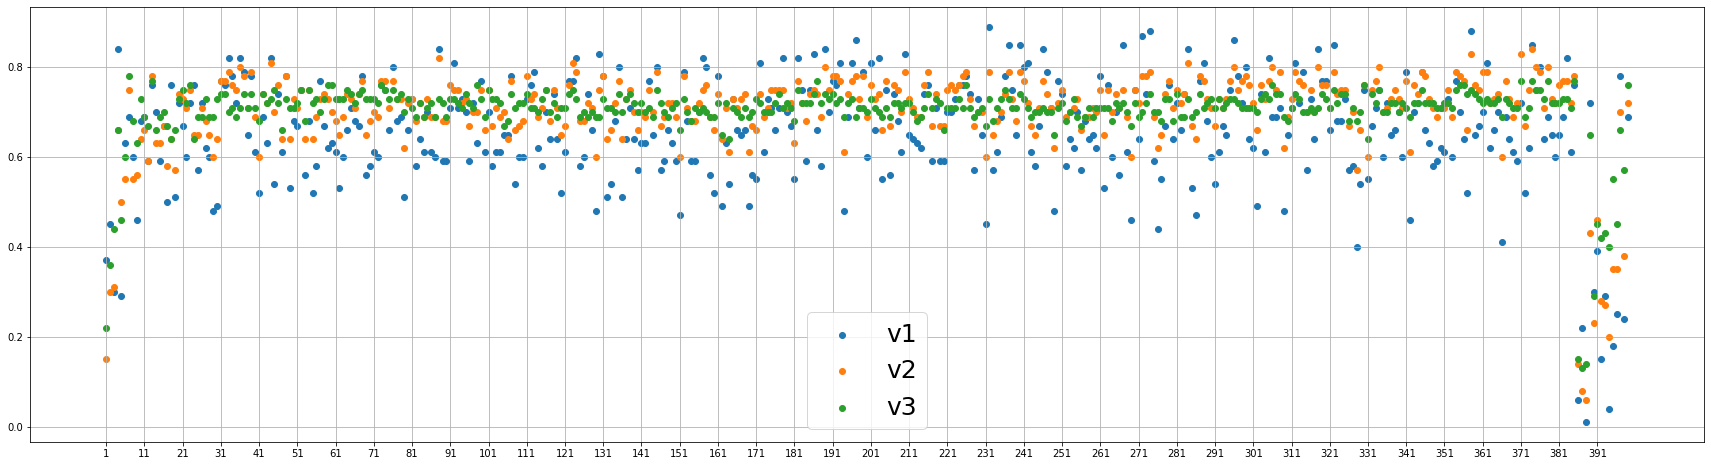

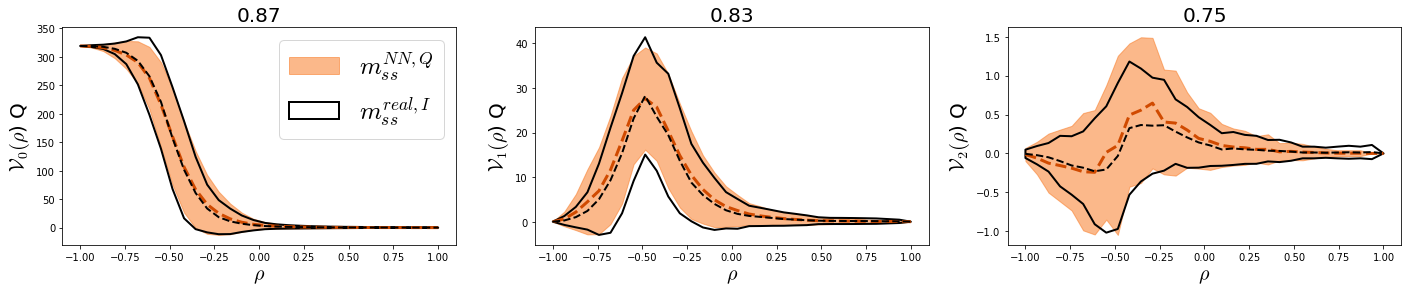

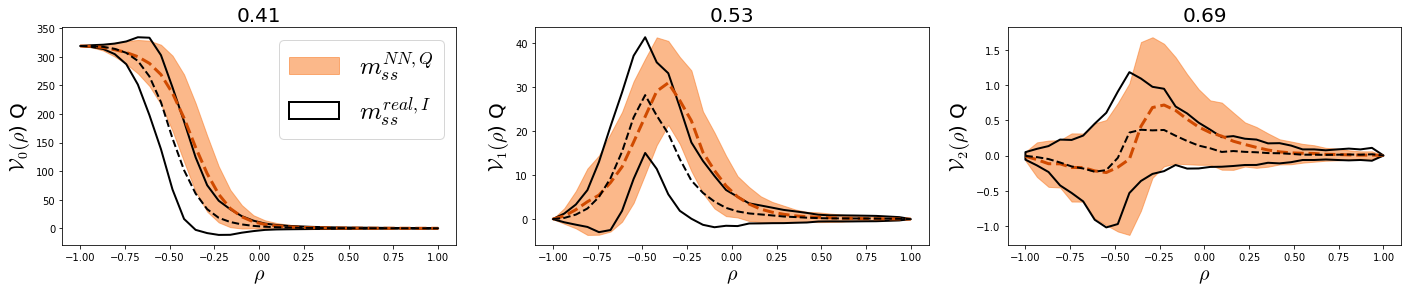

In [165]:
data_dir = '/pscratch/sd/j/jianyao/forse_output/Random_snr_1_training_data_Nico_T12amin_Q80amin.npy'
model_dir = '/pscratch/sd/j/jianyao/forse_output/Random_12amin_MY_lr_5e-5_Q_jupyter_snr_1/'
MF_dir = 'MFs/Random_snr_1_Q_jupyter_348_MFs_lr_5e-5.txt'

results = get_MFs(input_patches=174, data_dir = data_dir, model_dir = model_dir, MF_dir = MF_dir)
plot_MF(results, 'Q', savedir = False)

## test the model with another realization of noise
test_noise = '/pscratch/sd/j/jianyao/forse_output/Random_1_testing_data_Nico_T12amin_Q80amin.npy'
data_test = np.load(test_noise)[:, 0:174]

results_test = get_MFs(input_patches=174, data_dir = data_test, model_dir = model_dir, MF_dir = MF_dir, best_epoch = results[10], save_NN='/pscratch/sd/j/jianyao/forse_output/NN_small_scales/Random_1_NNout_Q.npy')
plot_MF(results_test, 'Q', savedir = False)

179

{179, 0.750} {13, 0.750}
[0.8  0.74 0.71] [0.79 0.76 0.7 ]
NNout.shape: (174, 320, 320, 1)
0.80 0.73 0.71
NNout.shape: (174, 320, 320, 1)
0.41 0.54 0.65


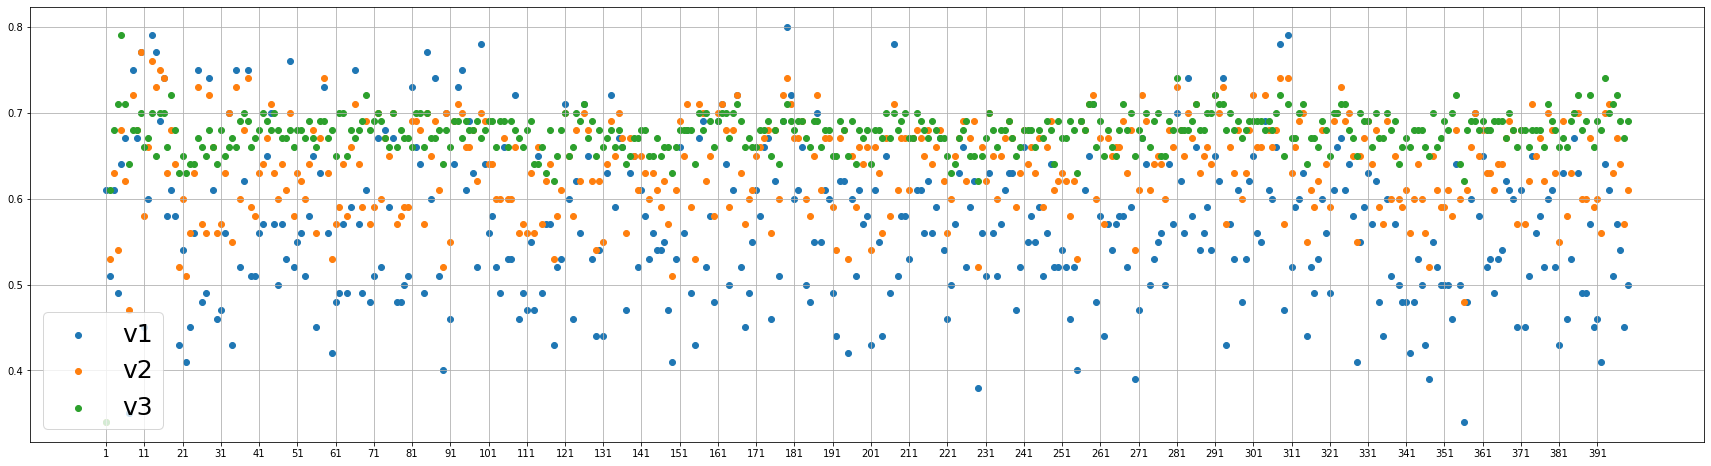

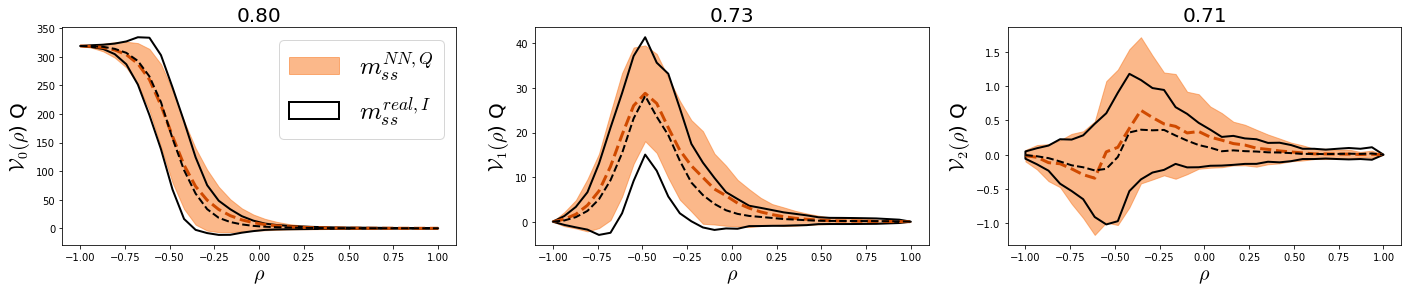

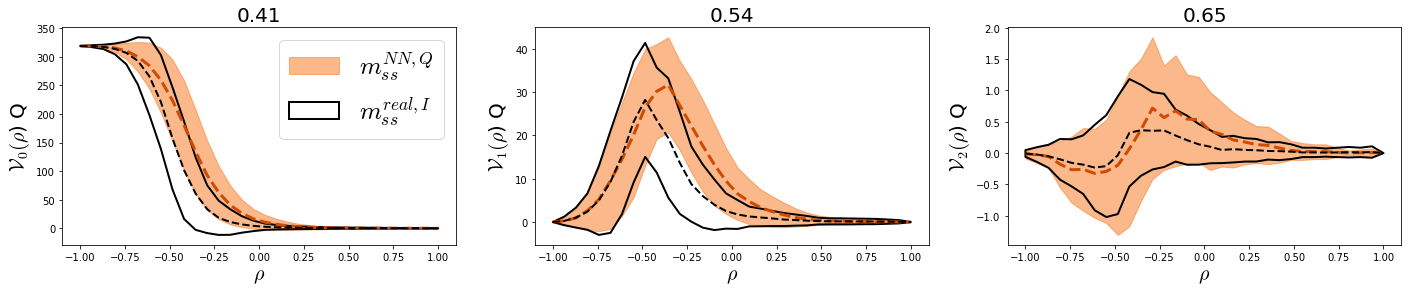

In [166]:
data_dir = '/pscratch/sd/j/jianyao/forse_output/Random_snr_0p1_training_data_Nico_T12amin_Q80amin.npy'
model_dir = '/pscratch/sd/j/jianyao/forse_output/Random_12amin_MY_lr_5e-5_Q_jupyter_snr_0p1/'
MF_dir = 'MFs/Random_snr_0p1_Q_jupyter_348_MFs_lr_5e-5.txt'

results = get_MFs(input_patches=174, data_dir = data_dir, model_dir = model_dir, MF_dir = MF_dir)
plot_MF(results, 'Q', savedir = False)

## test the model with another realization of noise
test_noise = '/pscratch/sd/j/jianyao/forse_output/Random_0p1_testing_data_Nico_T12amin_Q80amin.npy'
data_test = np.load(test_noise)[:, 0:174]

results_test = get_MFs(input_patches=174, data_dir = data_test, model_dir = model_dir, MF_dir = MF_dir, best_epoch = results[10], save_NN='/pscratch/sd/j/jianyao/forse_output/NN_small_scales/Random_0p1_NNout_Q.npy')
plot_MF(results_test, 'Q', savedir = False)

### Map visualization

In [160]:
Thr, Ls_ori = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy') # in units of K
for i in range(Ls_ori.shape[0]):
        Ls_ori[i] = rescale_min_max(Ls_ori[i])
        
Thr, Ls_10 = np.load('/pscratch/sd/j/jianyao/forse_output/Random_training_data_Nico_T12amin_Q80amin.npy')
Thr, Ls_1 = np.load('/pscratch/sd/j/jianyao/forse_output/Random_snr_1_training_data_Nico_T12amin_Q80amin.npy')
Thr, Ls_0p1 = np.load('/pscratch/sd/j/jianyao/forse_output/Random_snr_0p1_training_data_Nico_T12amin_Q80amin.npy')

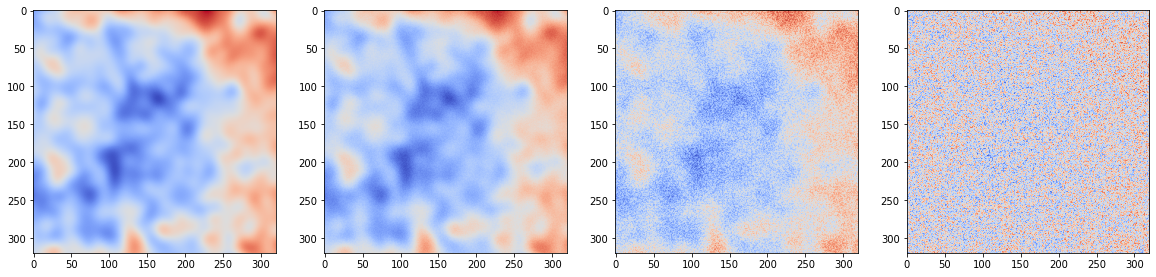

In [157]:
fig, axes = plt.subplots(1, 4, figsize = (20,15))
cm = axes[0].imshow(Ls_ori[33])

axes[1].imshow(Ls_10[33])
axes[2].imshow(Ls_1[33])
axes[3].imshow(Ls_0p1[33])

In [ ]:
NN_out_Q_10 = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/Random_10_NNout_Q.npy')
NN_out_Q_1 = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/Random_1_NNout_Q.npy')
NN_out_Q_1 = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/Random_1_NNout_Q.npy')

In [189]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

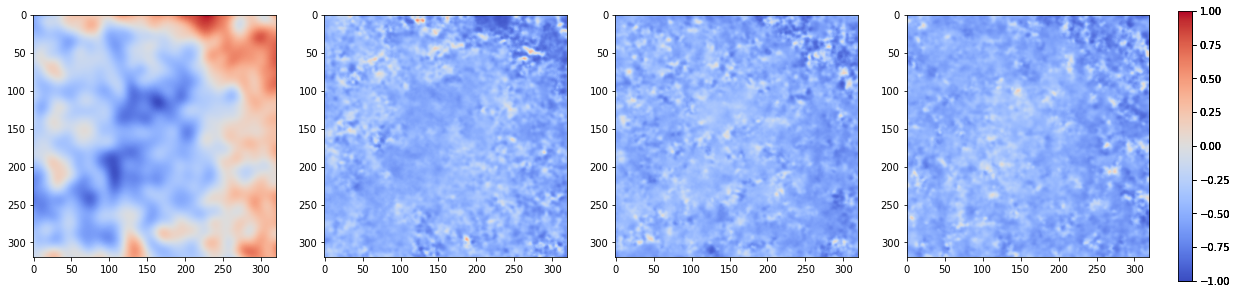

In [208]:
data_all = [Ls_ori, NN_out_Q_10, NN_out_Q_1, NN_out_Q_0p1]
fig, axes = plt.subplots(1, 4, figsize = (20,5))
for i in range(4):
   
    cm = axes[i].imshow(data_all[i][33], vmin = -1, vmax = 1)
    cax = fig.add_axes([0.92, 0.1, 0.01, 0.75])
    fig.colorbar(cm,cax = cax)

# Nico Forse

In [33]:
# Modified from: 
# https://github.com/eriklindernoren/Keras-GAN.git

class DCGAN:
    def __init__(self, output_directory, img_size, slack=False, slack_talk=False):
        self.img_size = img_size
        self.channels = 1
        self.kernel_size = 5
        self.output_directory = output_directory
        self.slack = slack; self.slack_talk = slack_talk;
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        tf.config.run_functions_eagerly(True)

    def smooth_accuracy(self, y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))   


    def build_generator(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        model = Sequential()
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same", input_shape=img_shape)) # 64x64x64
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same", strides=2)) #32x32x128
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Conv2D(256, kernel_size=self.kernel_size, padding="same", strides=2)) #16x16x256
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.5))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.5))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Conv2D(self.channels, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("tanh"))
        # img_in = Input(shape=img_shape)
        # img_out = model(img_in)
        # return Model(img_in, img_out)
        return model

    def build_discriminator(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        model = Sequential()
        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=1, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.25))
        model.add(Dense(1, activation='sigmoid'))
        # img = Input(shape=img_shape)
        # validity = model(img)
        # return Model(img, validity)
        return model
    
#     def build_gan(self):
#         img_shape = (self.img_size[0], self.img_size[1], self.channels)
#         optimizer = Adam(0.0002, 0.5)

#         self.discriminator = self.build_discriminator()
#         self.discriminator.compile(loss='binary_crossentropy',
#                     optimizer=optimizer,
#                     metrics=['accuracy'])

#         self.generator = self.build_generator()
#         self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

#         z = Input(shape=img_shape)
#         img = self.generator(z)
#         self.discriminator.trainable = False
#         valid = self.discriminator(img)
#         self.combined = Model(z, valid)
#         self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    @tf.function
    def train_step(self, noise, images, generator, discriminator):
        # noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        generator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    
    def train(self, epochs, patches_file, batch_size=32, save_interval=100, seed=4324):
        self.start = time.time()
        self.epochs = epochs

        X_train, X_test, Y_train, Y_test = load_training_set(patches_file, seed=seed); # X-input large scales; Y-real small scales
        print("Training Data Shape: ", X_train.shape)
        half_batch = batch_size // 2
        accs = []
        # self.discriminator.summary()
        
        generator = self.build_generator()
        discriminator = self.build_discriminator()
        
        for epoch in range(epochs):
            self.epoch = epoch
            self.time = time.time()
        
            ind_batch = np.random.randint(0, X_train.shape[0], batch_size)
            
            idxX = np.random.randint(0, X_train.shape[0], half_batch)
            idxY = np.random.randint(0, X_train.shape[0], half_batch)

            
            self.train_step(X_train[ind_batch], Y_train[idxY], generator, discriminator)

            
            if epoch % (save_interval) == 0 and epoch > 0:
                message = 'You are at epoch %s ! Time cost is %0.2f mins! ETA: %0.2f hours!'%(epoch, (self.time-self.start)/60, (self.epochs - self.epoch)*(self.time-self.start)/60/60/self.epoch)
                print(message)
                # gen_imgs_test = self.generator.predict(X_test)
                save_path = self.output_directory + "/models"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.discriminator.save(save_path + '/discrim_'+str(epoch)+'.h5')
                self.generator.save(save_path + '/generat_'+str(epoch)+'.h5')
        self.discriminator.save(save_path + '/discrim_'+str(epoch)+'.h5')
        self.generator.save(save_path + '/generat_'+str(epoch)+'.h5')
